<a href="https://colab.research.google.com/github/jonathanbff/Hackas/blob/main/Master_Datamaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Tuple
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Classe: DataProcessor

### Descrição
A classe `DataProcessor` realiza o carregamento, limpeza e processamento de dados para análise de churn. Além disso, otimiza os tipos de dados e prepara amostras para facilitar a análise exploratória.

### Métodos

#### `__init__(self, members_path: str, transactions_path: str)`
- **Descrição**: Inicializa os caminhos para os arquivos `members` e `transactions`.
- **Parâmetros**:
  - `members_path` (str): Caminho para o arquivo `members`.
  - `transactions_path` (str): Caminho para o arquivo `transactions`.

#### `load_and_process_data(self)`
- **Descrição**: Realiza o pipeline de carregamento e processamento de dados.
- **Etapas**:
  - Carrega os arquivos.
  - Otimiza os tipos de dados.
  - Processa as datas.
  - Limpa os dados de membros.
  - Cria amostras e variável de churn.
- **Retorno**: `pd.DataFrame` com os dados processados.

#### `_optimize_dtypes(self, members: pd.DataFrame, transactions: pd.DataFrame)`
- **Descrição**: Otimiza os tipos de dados para reduzir o uso de memória.
- **Retorno**: Tupla de `pd.DataFrame` contendo os dados otimizados.

#### `_process_dates(self, members: pd.DataFrame, transactions: pd.DataFrame)`
- **Descrição**: Converte colunas de datas para o formato datetime.
- **Retorno**: Tupla de `pd.DataFrame` com datas processadas.

#### `_clean_members_data(self, members: pd.DataFrame)`
- **Descrição**: Limpa os dados de membros, corrigindo valores inconsistentes e preenchendo valores ausentes.
- **Retorno**: `pd.DataFrame` limpo.

#### `_create_sample(self, members: pd.DataFrame, transactions: pd.DataFrame, sample_size: float = 0.01)`
- **Descrição**: Cria uma amostra dos dados para facilitar o processamento.
- **Parâmetros**:
  - `sample_size` (float): Percentual de dados para a amostra (padrão: 1%).
- **Retorno**: Tupla de `pd.DataFrame` com amostras.

#### `_create_churn_variable(self, df: pd.DataFrame)`
- **Descrição**: Cria a variável de churn baseada em um intervalo de três meses.
- **Retorno**: `pd.DataFrame` com a variável de churn.

---

## Classe: EdaPrint

### Descrição
A classe `EdaPrint` realiza a análise exploratória dos dados, incluindo informações básicas, valores faltantes, análise numérica e categórica, e correlações.

### Métodos

#### `__init__(self, df_original, df_processed, feature_names)`
- **Descrição**: Inicializa os dados originais, processados e a lista de features.
- **Parâmetros**:
  - `df_original`: Dados originais.
  - `df_processed`: Dados processados.
  - `feature_names`: Lista de features para análise.

#### `get_basic_info(self)`
- **Descrição**: Exibe informações básicas sobre o dataset.

#### `get_missing_values_info(self)`
- **Descrição**: Analisa valores faltantes antes e depois do processamento.

#### `get_numeric_analysis(self)`
- **Descrição**: Realiza análise estatística de variáveis numéricas.

#### `get_categorical_analysis(self)`
- **Descrição**: Analisa distribuição de variáveis categóricas.

#### `get_correlation_analysis(self)`
- **Descrição**: Identifica correlações fortes entre variáveis numéricas.

#### `get_target_analysis(self)`
- **Descrição**: Analisa a relação das features com a variável target (`churn`).

#### `generate_full_report(self)`
- **Descrição**: Gera um relatório completo de análise exploratória.

---

## Função Principal: `main()`

- **Descrição**: Executa o pipeline completo de processamento e análise de dados.
- **Etapas**:
  1. Configuração inicial.
  2. Processamento de dados usando `DataProcessor`.
  3. Preparação para análise exploratória com `EdaPrint`.
  4. Geração e salvamento do relatório.
- **Retorno**:
  - `df_final`: Dados processados com variável de churn.
  - `eda_analysis`: Instância de `EdaPrint` com análise exploratória.

---

In [ ]:


class DataProcessor:
    def __init__(self, members_path: str, transactions_path: str):
        self.members_path = members_path
        self.transactions_path = transactions_path

    def load_and_process_data(self):
        """Carrega e processa os dados iniciais."""
        # Montando o Google Drive
        drive.mount('/content/drive')

        # Carregando os dados
        members = pd.read_parquet(self.members_path)
        transactions = pd.read_parquet(self.transactions_path)

        members, transactions = self._optimize_dtypes(members, transactions)
        members, transactions = self._process_dates(members, transactions)
        members = self._clean_members_data(members)

        members_sample, transactions_sample = self._create_sample(members, transactions)
        transactions_sample = transactions_sample.set_index(['msno', 'safra'])
        members_sample = members_sample.set_index(['msno', 'safra'])

        final_df = members_sample.join(transactions_sample, how='left')
        final_df_with_churn = self._create_churn_variable(final_df)

        return final_df_with_churn

    def _optimize_dtypes(self, members: pd.DataFrame, transactions: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Otimiza os tipos de dados dos dataframes."""
        # Otimização members
        members['bd'] = pd.to_numeric(members['bd'], errors='coerce').astype('Int16')
        members['city'] = members['city'].astype('Int16')
        members['registered_via'] = members['registered_via'].astype('Int16')

        # Otimização transactions
        transactions['payment_method_id'] = transactions['payment_method_id'].astype('Int16')
        transactions['payment_plan_days'] = transactions['payment_plan_days'].astype('Int16')
        transactions['plan_list_price'] = transactions['plan_list_price'].astype('float32')
        transactions['actual_amount_paid'] = transactions['actual_amount_paid'].astype('float32')
        transactions['is_auto_renew'] = transactions['is_auto_renew'].astype('Int8')
        transactions['is_cancel'] = transactions['is_cancel'].astype('Int8')

        return members, transactions

    def _process_dates(self, members: pd.DataFrame, transactions: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Processa as colunas de data."""
        members['safra'] = pd.to_datetime(members['safra'], format='%Y%m')
        transactions['safra'] = pd.to_datetime(transactions['safra'], format='%Y%m')
        members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
        transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')
        transactions['membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'], format='%Y%m%d')

        return members, transactions

    def _clean_members_data(self, members: pd.DataFrame) -> pd.DataFrame:
        """Limpa os dados dos membros."""
        members['bd'] = members['bd'].apply(lambda x: np.nan if x < 0 or x > 100 else x)
        members['gender'] = members['gender'].fillna('unknown')
        return members

    def _create_sample(self, members: pd.DataFrame, transactions: pd.DataFrame, sample_size: float = 0.01) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Cria uma amostra dos dados."""
        msno_sample = members['msno'].drop_duplicates().sample(frac=sample_size, random_state=42)
        members_sample = members[members['msno'].isin(msno_sample)]
        transactions_sample = transactions[transactions['msno'].isin(msno_sample)]
        return members_sample, transactions_sample

    def _create_churn_variable(self, df: pd.DataFrame) -> pd.DataFrame:
        """Cria a variável de churn."""
        df_sorted = df.sort_index().copy()
        df_sorted['is_ativo_futuro'] = df_sorted.groupby('msno')['is_ativo'].shift(-3).fillna(0)
        df_sorted['churn'] = np.where((df_sorted['is_ativo'] == 1) & (df_sorted['is_ativo_futuro'] == 0), 1, 0)
        return df_sorted

class EdaPrint:
    def __init__(self, df_original, df_processed, feature_names):
        self.df_original = df_original
        self.df_processed = df_processed
        self.feature_names = feature_names
        self.categorical_features = [
            'gender', 'city', 'registered_via', 'payment_method_id'
        ]
        self.numeric_features = [
            col for col in feature_names
            if col not in self.categorical_features
            and (pd.api.types.is_numeric_dtype(df_processed[col])
                 or pd.api.types.is_datetime64_any_dtype(df_processed[col])
                 or pd.api.types.is_timedelta64_dtype(df_processed[col]))
        ]

    def get_basic_info(self):
        """Informações básicas sobre o dataset"""
        info = []
        info.append("=== INFORMAÇÕES BÁSICAS ===")
        info.append(f"Número total de registros: {len(self.df_processed):,}")
        info.append(f"Número total de features: {len(self.feature_names)}")
        info.append(f"Features numéricas: {len(self.numeric_features)}")
        info.append(f"Features categóricas: {len(self.categorical_features)}")
        return "\n".join(info)

    def get_missing_values_info(self):
        """Análise de valores faltantes"""
        info = []
        info.append("\n=== ANÁLISE DE VALORES FALTANTES ===")

        # Valores faltantes originais
        missing_original = self.df_original.isnull().sum()
        missing_original_pct = (missing_original / len(self.df_original)) * 100
        missing_original = missing_original[missing_original > 0]

        info.append("\nValores faltantes nos dados originais:")
        for col in missing_original.index:
            info.append(f"{col}: {missing_original[col]:,} registros ({missing_original_pct[col]:.2f}%)")

        # Valores faltantes processados
        missing_processed = self.df_processed.isnull().sum()
        missing_processed_pct = (missing_processed / len(self.df_processed)) * 100
        missing_processed = missing_processed[missing_processed > 0]

        info.append("\nValores faltantes após processamento:")
        for col in missing_processed.index:
            info.append(f"{col}: {missing_processed[col]:,} registros ({missing_processed_pct[col]:.2f}%)")

        return "\n".join(info)

    def get_numeric_analysis(self):
        """Análise detalhada das variáveis numéricas"""
        info = []
        info.append("\n=== ANÁLISE DE VARIÁVEIS NUMÉRICAS ===")

        for feature in self.numeric_features:
            info.append(f"\nFeature: {feature}")
            data = self.df_processed[feature]

            # Verifica se a coluna é numérica
            if pd.api.types.is_numeric_dtype(data):
                # Estatísticas básicas
                info.append("Estatísticas básicas:")
                info.append(f"- Média: {data.mean():.2f}")
                info.append(f"- Mediana: {data.median():.2f}")
                info.append(f"- Desvio Padrão: {data.std():.2f}")
                info.append(f"- Mínimo: {data.min():.2f}")
                info.append(f"- Máximo: {data.max():.2f}")

                # Quartis
                q25, q75 = data.quantile([0.25, 0.75])
                info.append(f"- Q1 (25%): {q25:.2f}")
                info.append(f"- Q3 (75%): {q75:.2f}")

                # Identificação de outliers
                iqr = q75 - q25
                outliers = data[(data < (q25 - 1.5 * iqr)) | (data > (q75 + 1.5 * iqr))]
                info.append(f"- Número de outliers: {len(outliers):,} ({(len(outliers)/len(data))*100:.2f}%)")

                # Assimetria e Curtose
                info.append(f"- Assimetria: {data.skew():.2f}")
                info.append(f"- Curtose: {data.kurtosis():.2f}")

            # Se for datetime
            elif pd.api.types.is_datetime64_any_dtype(data):
                info.append("Estatísticas temporais:")
                info.append(f"- Data mais antiga: {data.min()}")
                info.append(f"- Data mais recente: {data.max()}")
                info.append(f"- Período total: {data.max() - data.min()}")

            # Se for timedelta
            elif pd.api.types.is_timedelta64_dtype(data):
                info.append("Estatísticas de intervalo:")
                info.append(f"- Intervalo médio: {data.mean()}")
                info.append(f"- Intervalo mínimo: {data.min()}")
                info.append(f"- Intervalo máximo: {data.max()}")

            else:
                info.append("Tipo de dados não suportado para análise numérica")

        return "\n".join(info)

    def get_categorical_analysis(self):
        """Análise detalhada das variáveis categóricas"""
        info = []
        info.append("\n=== ANÁLISE DE VARIÁVEIS CATEGÓRICAS ===")

        for feature in self.categorical_features:
            info.append(f"\nFeature: {feature}")
            value_counts = self.df_processed[feature].value_counts()
            value_counts_pct = value_counts / len(self.df_processed) * 100

            info.append("Distribuição de categorias:")
            for val, count in value_counts.items():
                info.append(f"- {val}: {count:,} registros ({value_counts_pct[val]:.2f}%)")

            info.append(f"Número de categorias únicas: {len(value_counts)}")

        return "\n".join(info)

    def get_correlation_analysis(self):
        """Análise de correlações entre variáveis numéricas"""
        info = []
        info.append("\n=== ANÁLISE DE CORRELAÇÕES ===")

        # Filtrando apenas colunas numéricas para correlação
        numeric_cols = [col for col in self.numeric_features
                       if pd.api.types.is_numeric_dtype(self.df_processed[col])]

        if numeric_cols:
            # Calculando correlações
            corr_matrix = self.df_processed[numeric_cols].corr()

            # Encontrando correlações mais fortes
            correlations = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i):
                    if i != j:
                        correlations.append((
                            corr_matrix.index[i],
                            corr_matrix.columns[j],
                            abs(corr_matrix.iloc[i, j])
                        ))

            correlations.sort(key=lambda x: x[2], reverse=True)

            info.append("\nCorrelações mais fortes:")
            for f1, f2, corr in correlations[:10]:
                info.append(f"- {f1} - {f2}: {corr:.3f}")
        else:
            info.append("\nNenhuma variável numérica disponível para análise de correlação")

        return "\n".join(info)

    def get_target_analysis(self):
        """Análise da relação com a variável target (churn)"""
        info = []
        info.append("\n=== ANÁLISE DA RELAÇÃO COM CHURN ===")

        if 'churn' in self.df_processed.columns:
            # Distribuição geral do churn
            churn_dist = self.df_processed['churn'].value_counts()
            churn_pct = churn_dist / len(self.df_processed) * 100

            info.append("\nDistribuição do Churn:")
            info.append(f"- Não Churn (0): {churn_dist[0]:,} ({churn_pct[0]:.2f}%)")
            info.append(f"- Churn (1): {churn_dist[1]:,} ({churn_pct[1]:.2f}%)")

            # Análise para features numéricas
            numeric_cols = [col for col in self.numeric_features
                          if pd.api.types.is_numeric_dtype(self.df_processed[col])]

            if numeric_cols:
                info.append("\nAnálise de features numéricas vs Churn:")
                for feature in numeric_cols:
                    if feature != 'churn':
                        avg_by_churn = self.df_processed.groupby('churn')[feature].mean()
                        std_by_churn = self.df_processed.groupby('churn')[feature].std()

                        info.append(f"\n{feature}:")
                        info.append(f"- Média (Não Churn): {avg_by_churn[0]:.2f}")
                        info.append(f"- Média (Churn): {avg_by_churn[1]:.2f}")
                        info.append(f"- Desvio Padrão (Não Churn): {std_by_churn[0]:.2f}")
                        info.append(f"- Desvio Padrão (Churn): {std_by_churn[1]:.2f}")

                        # Teste estatístico
                        try:
                            stat, p_value = stats.mannwhitneyu(
                                self.df_processed[self.df_processed['churn']==0][feature].dropna(),
                                self.df_processed[self.df_processed['churn']==1][feature].dropna()
                            )
                            info.append(f"- p-value: {p_value:.4f}")
                        except:
                            info.append("- Teste estatístico não pôde ser realizado")

            # Análise para features categóricas
            info.append("\nAnálise de features categóricas vs Churn:")
            for feature in self.categorical_features:
                cross_tab = pd.crosstab(
                    self.df_processed[feature],
                    self.df_processed['churn'],
                    normalize='index'
                ) * 100

                info.append(f"\n{feature}:")
                for category in cross_tab.index:
                    info.append(f"- {category}: Taxa de Churn = {cross_tab.loc[category, 1]:.2f}%")

        return "\n".join(info)

    def generate_full_report(self):
        """Gera relatório completo"""
        report_parts = [
            self.get_basic_info(),
            self.get_missing_values_info(),
            self.get_numeric_analysis(),
            self.get_categorical_analysis(),
            self.get_correlation_analysis(),
            self.get_target_analysis()
        ]

        # Adiciona timestamp ao relatório
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        header = f"RELATÓRIO DE ANÁLISE EXPLORATÓRIA DE DADOS\nGerado em: {timestamp}\n"

        full_report = header + "\n".join(report_parts)

        return full_report

def main():
    """Função principal que executa todo o pipeline de análise."""
    # Configuração inicial
    pd.set_option('display.max_columns', None)

    # Caminhos dos arquivos
    members_path = "/content/drive/MyDrive/Data_master/members.parquet"
    transactions_path = "/content/drive/MyDrive/Data_master/transactions.parquet"

    # Processamento dos dados
    processor = DataProcessor(members_path, transactions_path)
    df_com_churn = processor.load_and_process_data()

    # Preparação para análise exploratória
    feature_names = [col for col in df_com_churn.columns
                    if col not in ['churn', 'is_ativo', 'is_ativo_futuro']]

    # Criação da instância de EdaPrint e geração do relatório
    eda_print = EdaPrint(
        df_original=df_com_churn,
        df_processed=df_com_churn,
        feature_names=feature_names
    )

    # Gerar relatório
    report = eda_print.generate_full_report()

    # Imprimir relatório
    print(report)

    # Salvar relatório em arquivo
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_filename = f'eda_report_{timestamp}.txt'

    with open(report_filename, 'w', encoding='utf-8') as f:
        f.write(report)

    print(f"\nRelatório salvo em: {report_filename}")

    return df_com_churn, eda_print

if __name__ == "__main__":
    df_final, eda_analysis = main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
RELATÓRIO DE ANÁLISE EXPLORATÓRIA DE DADOS
Gerado em: 2024-12-14 15:33:23
=== INFORMAÇÕES BÁSICAS ===
Número total de registros: 638,878
Número total de features: 13
Features numéricas: 9
Features categóricas: 4

=== ANÁLISE DE VALORES FALTANTES ===

Valores faltantes nos dados originais:
bd: 592 registros (0.09%)
payment_method_id: 545,561 registros (85.39%)
payment_plan_days: 545,561 registros (85.39%)
plan_list_price: 545,561 registros (85.39%)
actual_amount_paid: 545,561 registros (85.39%)
is_auto_renew: 545,561 registros (85.39%)
transaction_date: 545,561 registros (85.39%)
membership_expire_date: 545,561 registros (85.39%)
is_cancel: 545,561 registros (85.39%)

Valores faltantes após processamento:
bd: 592 registros (0.09%)
payment_method_id: 545,561 registros (85.39%)
payment_plan_days: 545,561 registros (85.39%)
plan_list_price: 545,561 registros (85.

Iniciando processamento dos dados...


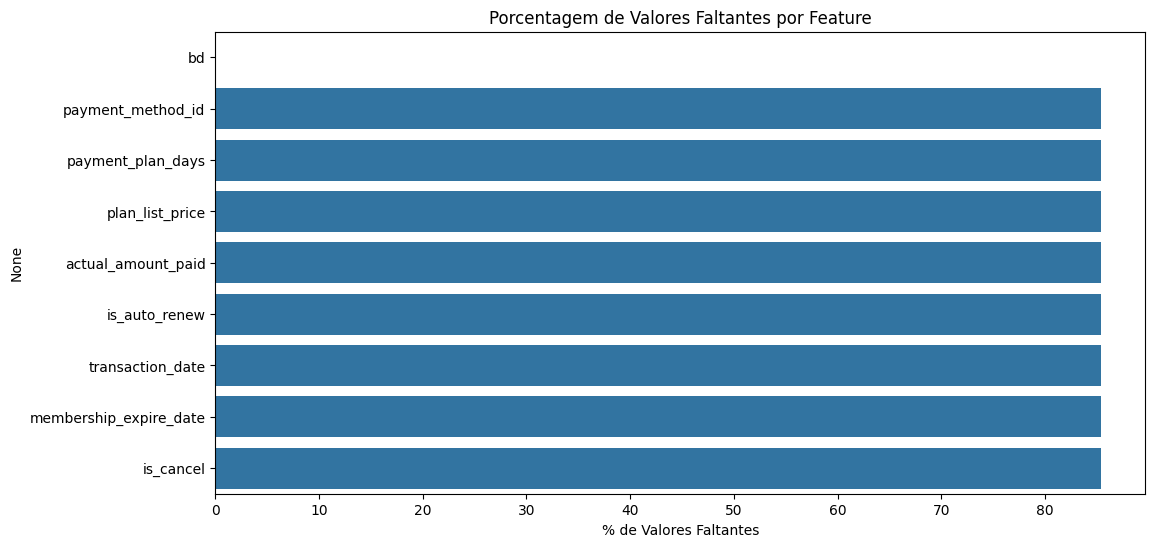

Valores faltantes visualizados
Features de transação tratadas
Features temporais criadas
Features categóricas tratadas
Features comportamentais criadas


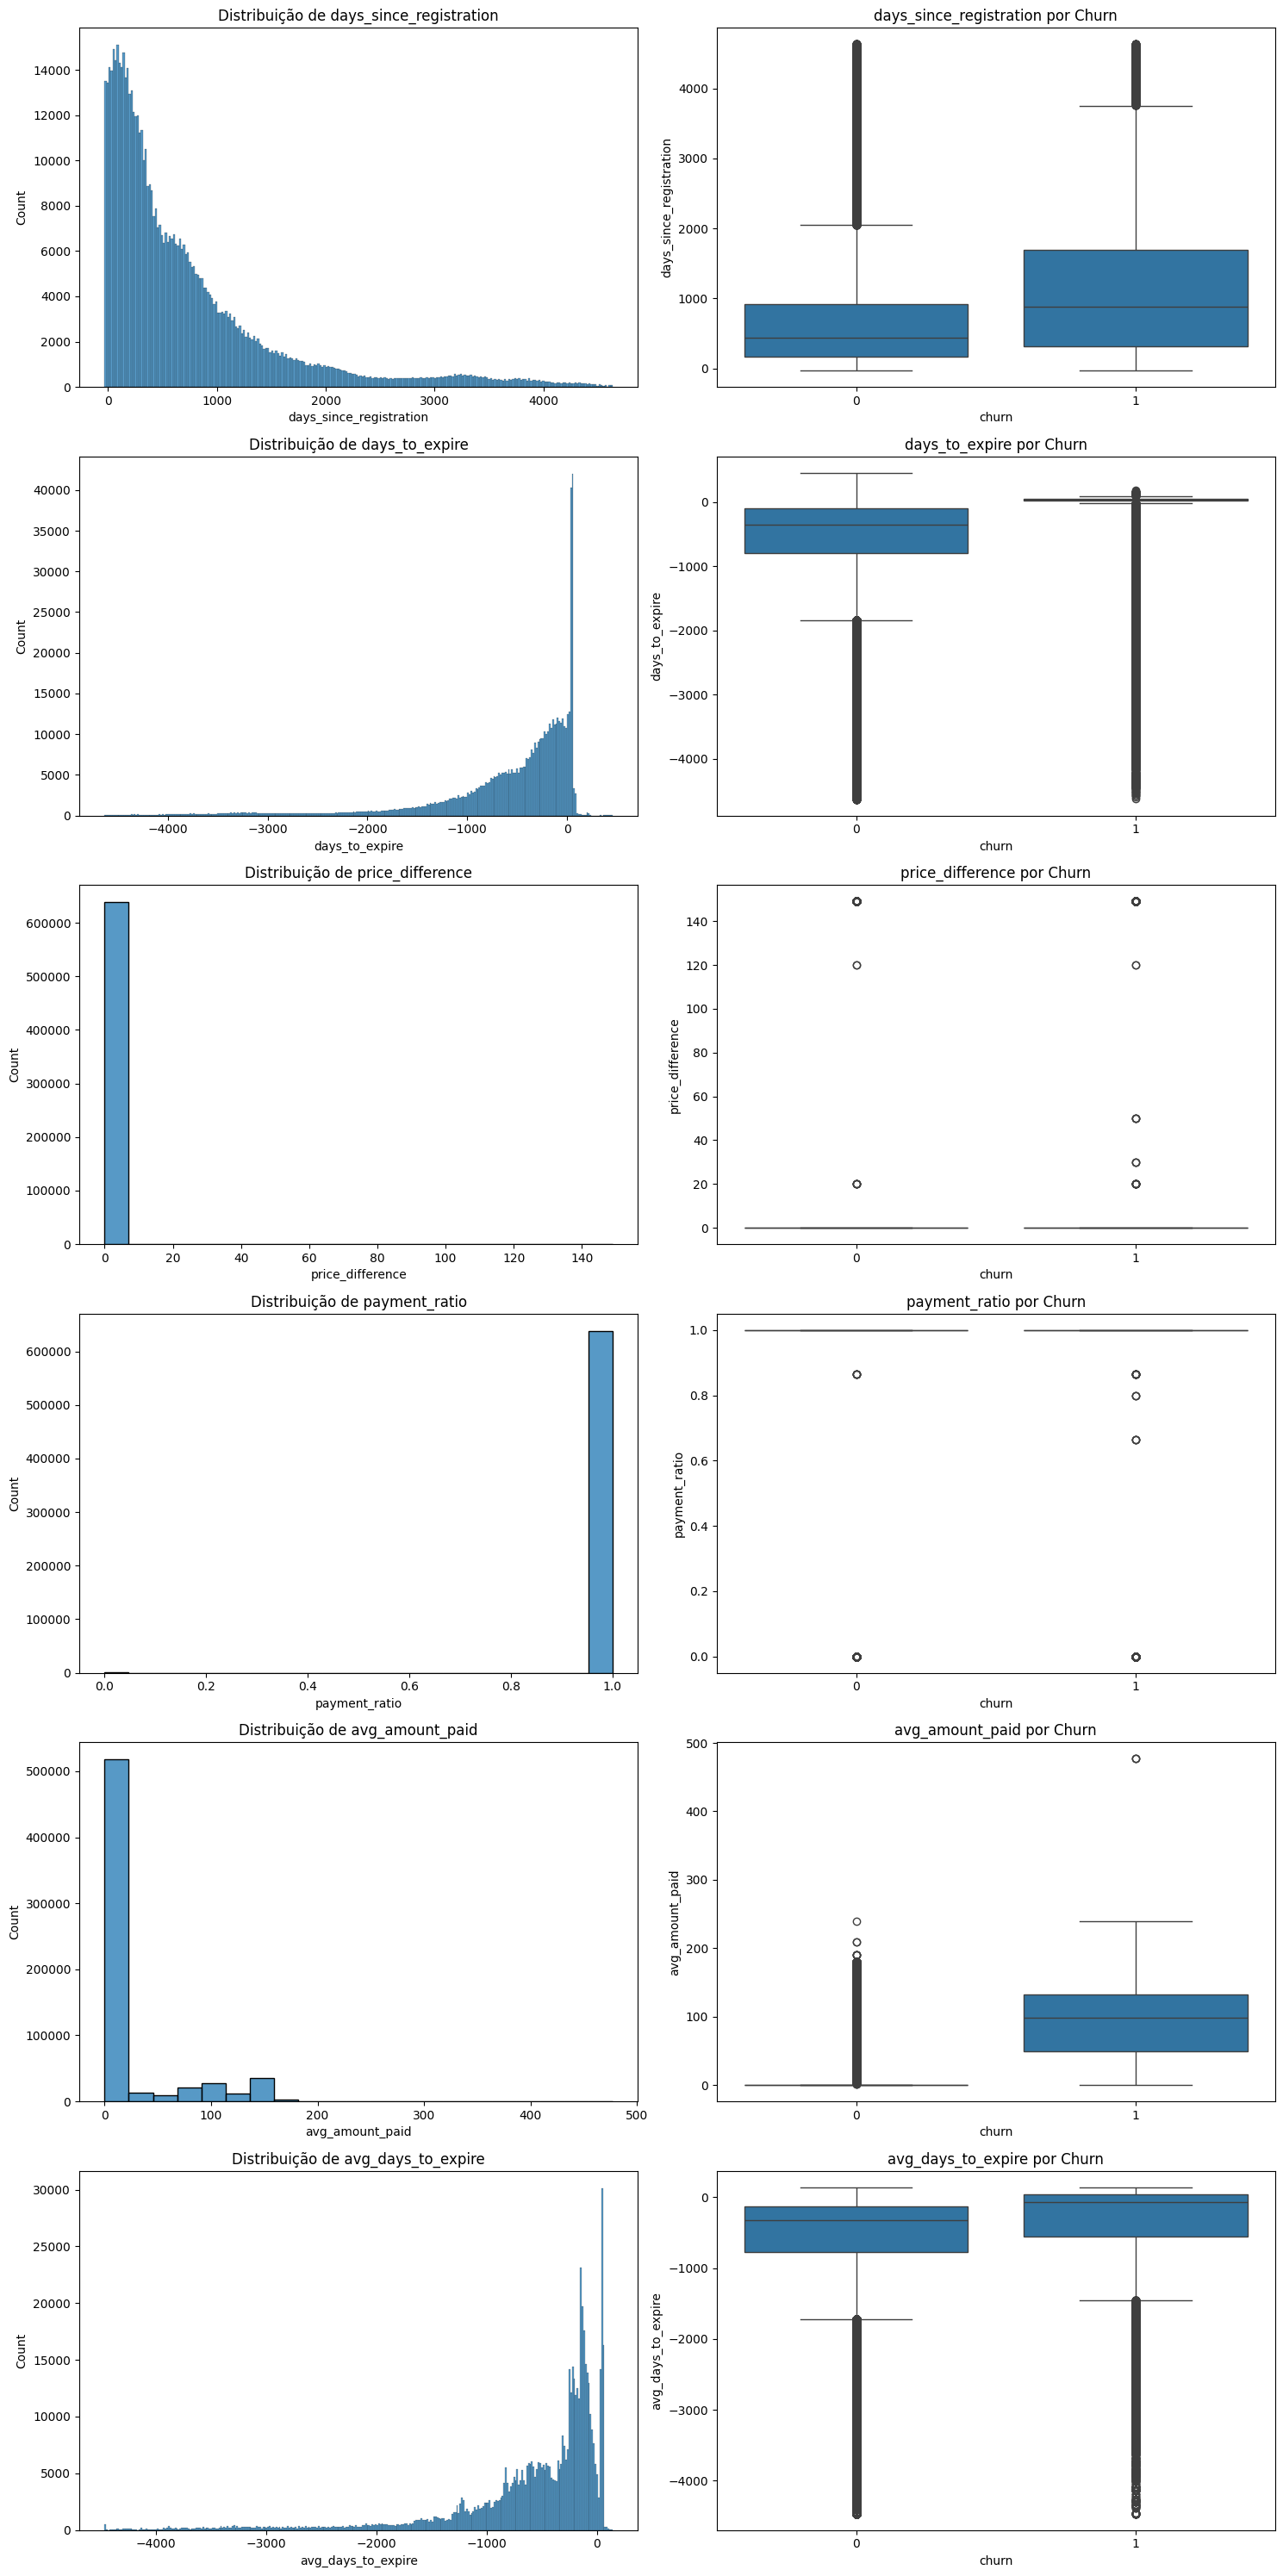

Distribuições plotadas

Informações do dataset processado:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 638878 entries, ('++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=', Timestamp('2016-01-01 00:00:00')) to ('zzvIV4yhbjEniXi2LyfWqYGKEW6/3AepdrV4x/t8wRk=', Timestamp('2016-12-01 00:00:00'))
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   registration_init_time   638878 non-null  datetime64[ns]
 1   city                     638878 non-null  Int16         
 2   bd                       638286 non-null  float64       
 3   gender                   638878 non-null  object        
 4   registered_via           638878 non-null  Int16         
 5   is_ativo                 638878 non-null  int32         
 6   payment_method_id        93317 non-null   Int16         
 7   payment_plan_days        638878 non-null  Int16         
 8   plan_list_price          638878 non-null  float3

In [ ]:


class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy()
        # Resetando o index para trabalhar com safra como coluna
        self.df = self.df.reset_index()

    def plot_missing_values(self):
        """Visualiza valores faltantes"""
        plt.figure(figsize=(12, 6))
        missing = (self.df.isnull().sum() / len(self.df)) * 100
        missing = missing[missing > 0].sort_values(ascending=True)

        sns.barplot(x=missing.values, y=missing.index)
        plt.title('Porcentagem de Valores Faltantes por Feature')
        plt.xlabel('% de Valores Faltantes')
        plt.show()

    def handle_transaction_features(self):
        """
        Trata features relacionadas a transações.
        Para usuários sem transações, vamos criar valores default ou derivados
        """
        # Criando features para identificar usuários sem transações
        self.df['has_transaction'] = self.df['payment_method_id'].notna().astype(int)

        # Preenchendo valores para usuários sem transações
        self.df['payment_plan_days'] = self.df['payment_plan_days'].fillna(0)
        self.df['plan_list_price'] = self.df['plan_list_price'].fillna(0)
        self.df['actual_amount_paid'] = self.df['actual_amount_paid'].fillna(0)
        self.df['is_auto_renew'] = self.df['is_auto_renew'].fillna(0)
        self.df['is_cancel'] = self.df['is_cancel'].fillna(0)

        # Preenchendo datas com a data de registro para quem não tem transação
        self.df['transaction_date'] = self.df['transaction_date'].fillna(self.df['registration_init_time'])
        self.df['membership_expire_date'] = self.df['membership_expire_date'].fillna(self.df['registration_init_time'])

        return self

    def create_temporal_features(self):
        """Cria features baseadas em datas"""
        # Tempo desde o registro
        self.df['days_since_registration'] = (
            self.df['safra'] - self.df['registration_init_time']).dt.days

        # Tempo até expiração da assinatura
        self.df['days_to_expire'] = (
            self.df['membership_expire_date'] - self.df['safra']).dt.days

        # Mês e dia da semana do registro
        self.df['registration_month'] = self.df['registration_init_time'].dt.month
        self.df['registration_weekday'] = self.df['registration_init_time'].dt.weekday

        return self

    def handle_categorical_features(self):
        """Trata features categóricas"""
        # Tratando gender
        self.df['gender'] = self.df['gender'].fillna('unknown')

        # Agrupando cidades por taxa de churn
        city_churn = self.df.groupby('city')['churn'].mean()
        city_risk = pd.qcut(city_churn, q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
        self.df['city_risk'] = self.df['city'].map(dict(zip(city_churn.index, city_risk)))

        # Agrupando payment_method_id por taxa de churn
        payment_churn = self.df.groupby('payment_method_id')['churn'].mean()
        payment_risk = pd.qcut(payment_churn, q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
        self.df['payment_risk'] = self.df['payment_method_id'].map(dict(zip(payment_churn.index, payment_risk)))

        return self

    def create_behavioral_features(self):
        """Cria features comportamentais"""
        # Diferença entre preço listado e valor pago
        self.df['price_difference'] = self.df['plan_list_price'] - self.df['actual_amount_paid']

        # Proporção do valor pago em relação ao preço listado
        self.df['payment_ratio'] = np.where(
            self.df['plan_list_price'] > 0,
            self.df['actual_amount_paid'] / self.df['plan_list_price'],
            1
        )

        # Features agregadas por usuário
        user_features = self.df.groupby('msno').agg({
            'has_transaction': 'mean',
            'is_auto_renew': 'mean',
            'is_cancel': 'mean',
            'actual_amount_paid': ['mean', 'std'],
            'days_to_expire': ['mean', 'min']
        }).round(2)

        # Renomeando as colunas agregadas
        user_features.columns = [
            'avg_has_transaction',
            'avg_auto_renew',
            'avg_cancel',
            'avg_amount_paid',
            'std_amount_paid',
            'avg_days_to_expire',
            'min_days_to_expire'
        ]

        # Juntando as features agregadas ao dataframe principal
        self.df = self.df.merge(user_features, on='msno', how='left')

        return self

    def plot_feature_distributions(self, features):
        """Plota distribuições das features numéricas"""
        n_features = len(features)
        fig, axes = plt.subplots(n_features, 2, figsize=(15, 5*n_features))

        for i, feature in enumerate(features):
            # Distribuição geral
            sns.histplot(data=self.df, x=feature, ax=axes[i,0])
            axes[i,0].set_title(f'Distribuição de {feature}')

            # Distribuição por churn
            sns.boxplot(data=self.df, x='churn', y=feature, ax=axes[i,1])
            axes[i,1].set_title(f'{feature} por Churn')

        plt.tight_layout()
        plt.show()

    def process_data(self):
        """Executa todo o pipeline de processamento"""
        print("Iniciando processamento dos dados...")

        self.plot_missing_values()
        print("Valores faltantes visualizados")

        self.handle_transaction_features()
        print("Features de transação tratadas")

        self.create_temporal_features()
        print("Features temporais criadas")

        self.handle_categorical_features()
        print("Features categóricas tratadas")

        self.create_behavioral_features()
        print("Features comportamentais criadas")

        # Plotando distribuições das novas features
        numerical_features = [
            'days_since_registration',
            'days_to_expire',
            'price_difference',
            'payment_ratio',
            'avg_amount_paid',
            'avg_days_to_expire'
        ]
        self.plot_feature_distributions(numerical_features)
        print("Distribuições plotadas")

        # Retornando o DataFrame com o index original
        final_df = self.df.set_index(['msno', 'safra'])
        return final_df

# Usando o preprocessador
preprocessor = DataPreprocessor(df_final)
df_processed = preprocessor.process_data()

# Exibindo informações do dataset processado
print("\nInformações do dataset processado:")
print(df_processed.info())

# Exibindo primeiras linhas
print("\nPrimeiras linhas do dataset processado:")
print(df_processed.head())

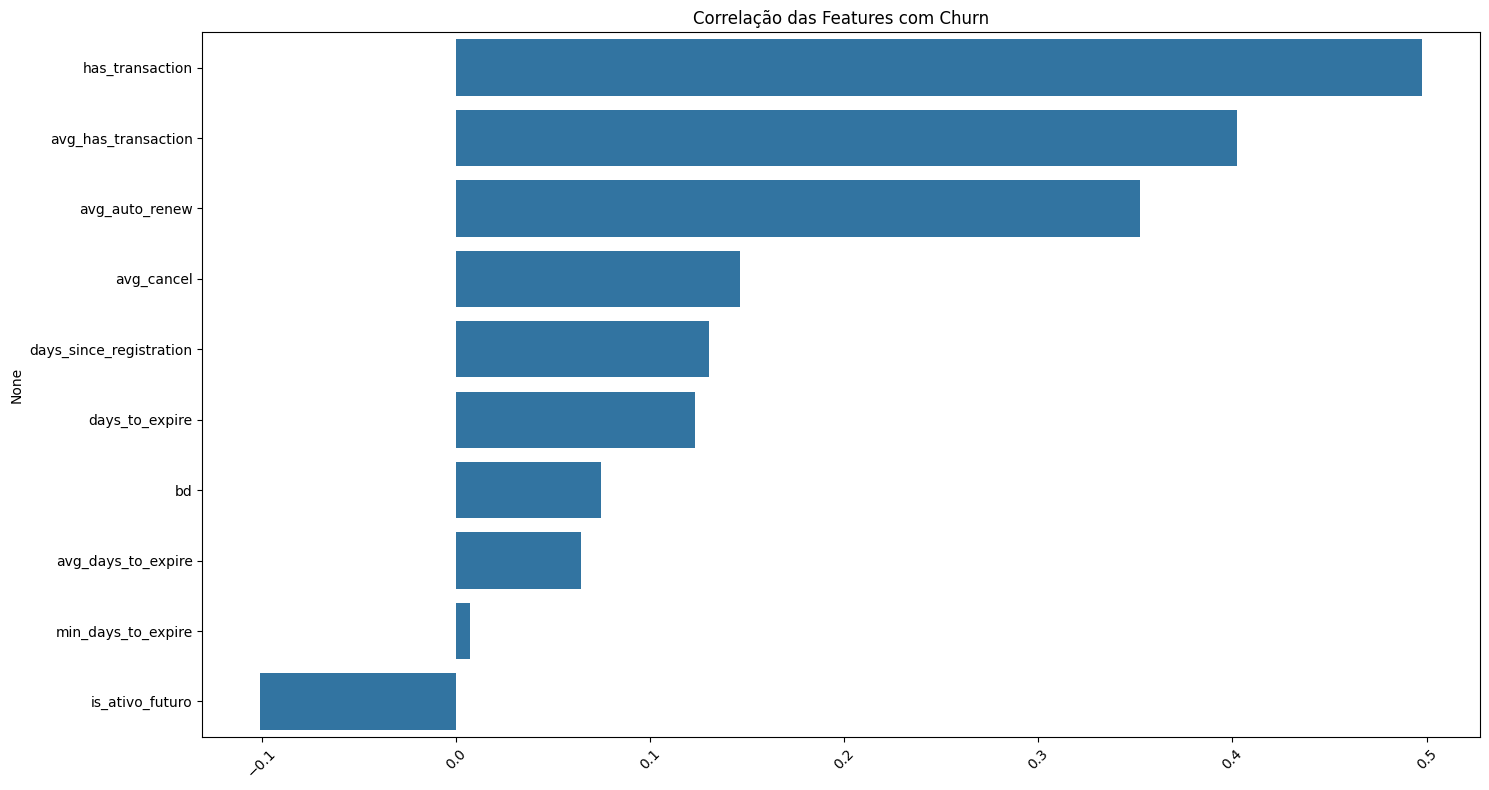

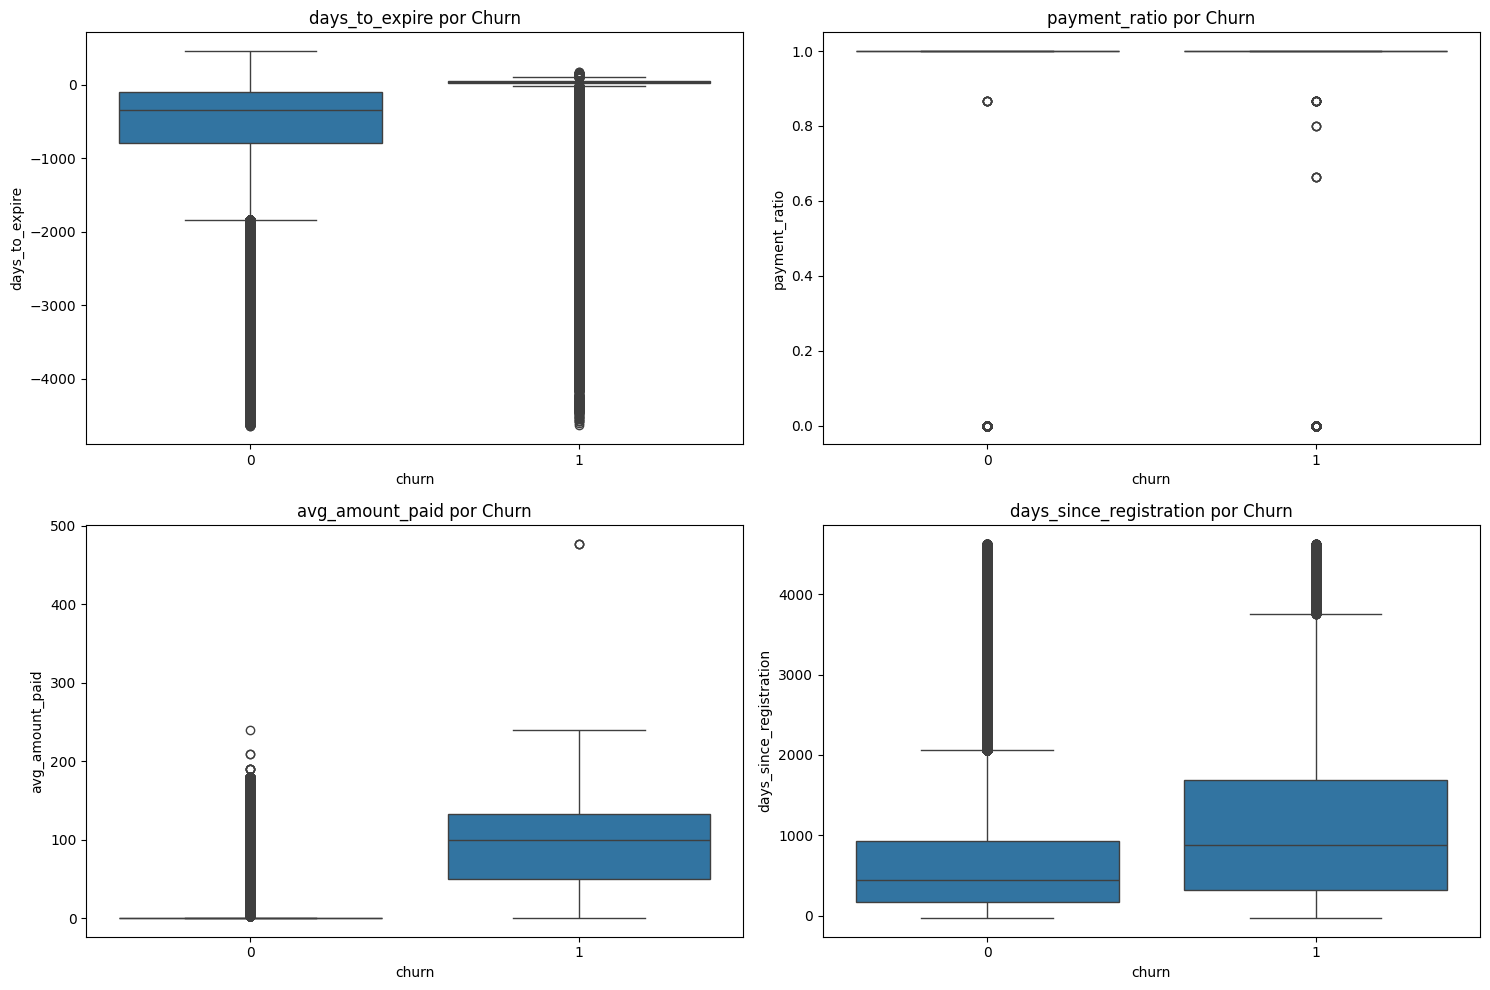

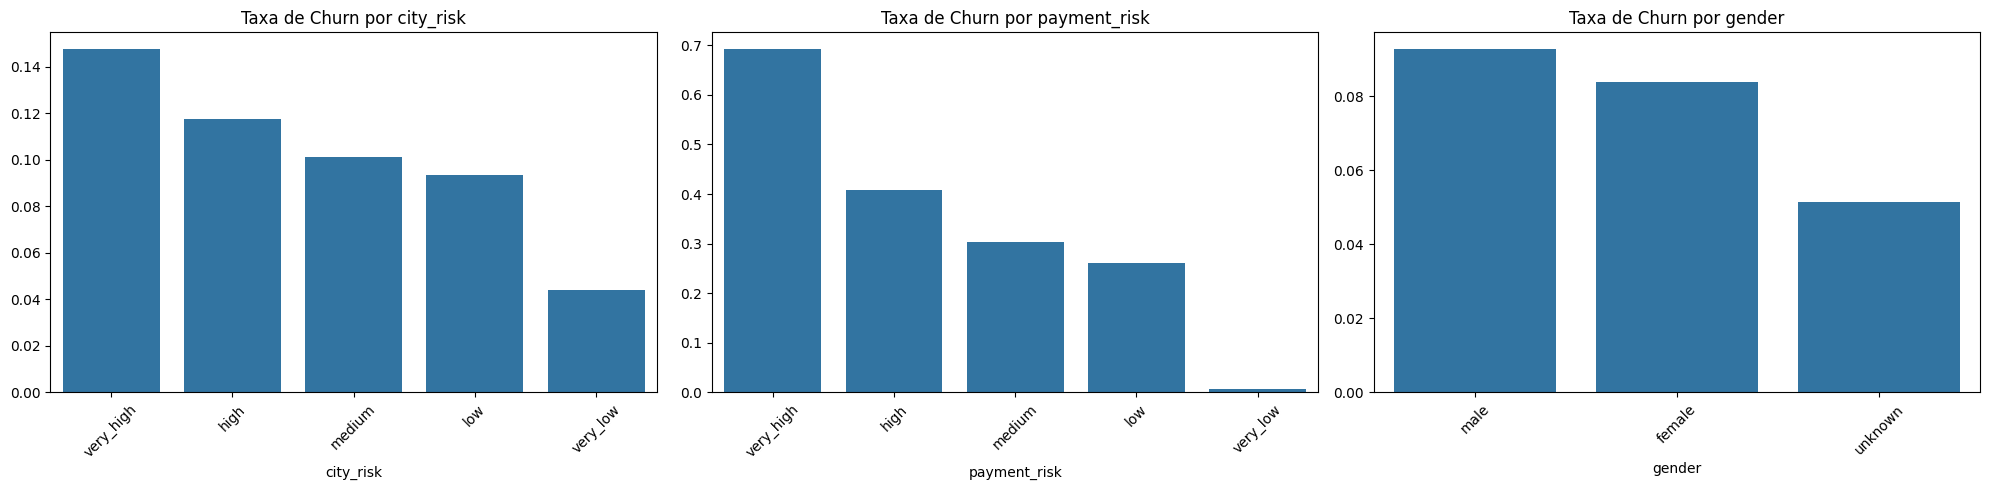

In [ ]:
def plot_feature_importance_for_churn(df):
    plt.figure(figsize=(15, 8))

    # Selecionando features numéricas
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    correlations = df[numeric_cols].corr()['churn'].sort_values(ascending=False)

    # Plotando correlações
    sns.barplot(x=correlations.values[1:], y=correlations.index[1:])
    plt.title('Correlação das Features com Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Análise de distribuições bivariadas
def plot_distributions(df):
    features_to_plot = ['days_to_expire', 'payment_ratio', 'avg_amount_paid', 'days_since_registration']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, feature in enumerate(features_to_plot):
        sns.boxplot(data=df, x='churn', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} por Churn')

    plt.tight_layout()
    plt.show()

# Análise categórica
def plot_categorical_analysis(df):
    categorical_features = ['city_risk', 'payment_risk', 'gender']

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for idx, feature in enumerate(categorical_features):
        if feature in df.columns:  # Verificando se a feature existe
            churn_rates = df.groupby(feature)['churn'].mean().sort_values(ascending=False)
            sns.barplot(x=churn_rates.index, y=churn_rates.values, ax=axes[idx])
            axes[idx].set_title(f'Taxa de Churn por {feature}')
            axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

# Executando as análises
plot_feature_importance_for_churn(df_processed)
plot_distributions(df_processed)
plot_categorical_analysis(df_processed)

In [ ]:
def analyze_new_features(df):
    print("\n=== ANÁLISE DAS NOVAS FEATURES ===\n")

    # 1. Features Temporais
    print("=== Features Temporais ===")
    temporal_features = ['days_since_registration', 'days_to_expire']
    for feature in temporal_features:
        print(f"\n{feature}:")
        print("Estatísticas descritivas:")
        print(df[feature].describe().round(2))
        print(f"Média para não-churn: {df[df['churn']==0][feature].mean():.2f}")
        print(f"Média para churn: {df[df['churn']==1][feature].mean():.2f}")

    # 2. Features Comportamentais
    print("\n=== Features Comportamentais ===")
    behavioral_features = ['payment_ratio', 'price_difference', 'avg_amount_paid', 'avg_auto_renew']
    for feature in behavioral_features:
        print(f"\n{feature}:")
        print("Estatísticas descritivas:")
        print(df[feature].describe().round(2))
        print(f"Média para não-churn: {df[df['churn']==0][feature].mean():.2f}")
        print(f"Média para churn: {df[df['churn']==1][feature].mean():.2f}")

    # 3. Features Categóricas
    print("\n=== Features Categóricas ===")
    categorical_features = ['city_risk', 'payment_risk']
    for feature in categorical_features:
        if feature in df.columns:
            print(f"\n{feature}:")
            churn_rates = df.groupby(feature)['churn'].agg(['count', 'mean']).round(4)
            print(churn_rates)

    # 4. Correlações com Churn
    print("\n=== Correlações com Churn ===")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    correlations = df[numeric_cols].corr()['churn'].sort_values(ascending=False)
    print("\nTop 10 correlações positivas:")
    print(correlations[1:11])  # Excluindo a própria correlação com churn
    print("\nTop 10 correlações negativas:")
    print(correlations[-10:])

# Executando a análise
analyze_new_features(df_processed)


=== ANÁLISE DAS NOVAS FEATURES ===

=== Features Temporais ===

days_since_registration:
Estatísticas descritivas:
count    638878.00
mean        744.13
std         846.10
min         -30.00
25%         177.00
50%         455.00
75%         971.00
max        4633.00
Name: days_since_registration, dtype: float64
Média para não-churn: 714.74
Média para churn: 1157.87

days_to_expire:
Estatísticas descritivas:
count    638878.00
mean       -575.81
std         774.56
min       -4633.00
25%        -774.00
50%        -319.00
75%         -68.00
max         455.00
Name: days_to_expire, dtype: float64
Média para não-churn: -601.23
Média para churn: -218.04

=== Features Comportamentais ===

payment_ratio:
Estatísticas descritivas:
count    638878.00
mean          1.00
std           0.03
min           0.00
25%           1.00
50%           1.00
75%           1.00
max           1.00
Name: payment_ratio, dtype: float64
Média para não-churn: 1.00
Média para churn: 0.99

price_difference:
Estatístic

1. Features Temporais:
- `days_since_registration`: Usuários que dão churn têm em média 1157 dias desde o registro, enquanto usuários que permanecem têm 714 dias. Isso sugere que clientes mais antigos têm maior probabilidade de churn.
- `days_to_expire`: A média negativa indica que muitos registros são de assinaturas já expiradas. Usuários com churn têm média de -218 dias, enquanto não-churn têm -601 dias.

2. Features Comportamentais:
- `payment_ratio`: Muito próximo de 1 para ambos os grupos, indicando que a maioria dos usuários paga o valor total.
- `price_difference`: Usuários que dão churn têm uma diferença média maior (1.36) comparado aos que permanecem (0.03), sugerindo mais descontos ou promoções.
- `avg_amount_paid`: Diferença significativa entre os grupos - churn tem média de 86.88 enquanto não-churn tem 15.24.
- `avg_auto_renew`: Usuários com churn têm taxa maior de renovação automática (0.53) vs não-churn (0.09).

3. Features Categóricas:
- `city_risk`:
  * Cidades 'very_high' têm taxa de churn de 14.74%
  * Cidades 'very_low' têm taxa de churn de apenas 4.40%
- `payment_risk`:
  * Métodos de pagamento 'very_high' têm taxa de churn de 69.12%
  * Métodos 'very_low' têm taxa de churn de apenas 0.72%

4. Correlações mais importantes com Churn:
- Positivas:
  * has_transaction (0.49)
  * avg_has_transaction (0.40)
  * avg_auto_renew (0.35)
  * days_since_registration (0.13)


# Preparação modelagem


In [ ]:
!pip install lightgbm
!pip install seaborn

import lightgbm as lgb
from sklearn.model_selection import train_test_split



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, precision_recall_curve, auc,
                           confusion_matrix, classification_report,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score)

class DataPreparator:
    def __init__(self, df):
        self.df = df.copy()
        self.label_encoders = {}
        self.scaler = StandardScaler()

    def prepare_data(self):
        """Prepara os dados para modelagem"""
        # 1. Tratamento de valores faltantes
        self.df = self.df.fillna({
            'gender': 'unknown',
            'city_risk': 'medium',
            'payment_risk': 'medium'
        })

        # 2. Features categóricas para encoding
        categorical_features = ['gender', 'city_risk', 'payment_risk']

        # 3. Features numéricas para normalização
        numeric_features = [
            'days_since_registration', 'days_to_expire',
            'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
            'price_difference', 'payment_ratio',
            'avg_has_transaction', 'avg_auto_renew', 'avg_cancel',
            'avg_amount_paid', 'avg_days_to_expire',
            'min_days_to_expire', 'bd', 'registered_via'
        ]

        # 4. Label Encoding para features categóricas
        for feature in categorical_features:
            if feature in self.df.columns:
                le = LabelEncoder()
                self.df[feature] = le.fit_transform(self.df[feature].astype(str))
                self.label_encoders[feature] = le

        # 5. Normalização das features numéricas
        numeric_data = self.df[numeric_features].copy()
        self.df[numeric_features] = self.scaler.fit_transform(numeric_data)

        # 6. Seleção final das features
        selected_features = numeric_features + categorical_features
        X = self.df[selected_features].copy()
        y = self.df['churn']

        return X, y

class ModelVisualizer:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred_proba = model.predict_proba(X_test)[:, 1]
        self.y_pred = (self.y_pred_proba > 0.5).astype(int)

    def plot_all_metrics(self):
        """Gera todos os plots relevantes em um grid"""
        # Configuração básica do matplotlib
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.rcParams['axes.grid'] = True
        plt.rcParams['font.size'] = 10

        fig = plt.figure(figsize=(20, 15))

        # 1. ROC Curve
        plt.subplot(2, 3, 1)
        self.plot_roc_curve()

        # 2. Precision-Recall Curve
        plt.subplot(2, 3, 2)
        self.plot_precision_recall_curve()

        # 3. Confusion Matrix
        plt.subplot(2, 3, 3)
        self.plot_confusion_matrix()

        # 4. Feature Importance
        plt.subplot(2, 3, 4)
        self.plot_feature_importance()

        # 5. Score Distribution
        plt.subplot(2, 3, 5)
        self.plot_score_distribution()

        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self):
        """Plot ROC Curve"""
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")

    def plot_precision_recall_curve(self):
        """Plot Precision-Recall Curve"""
        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_proba)
        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, color='blue', lw=2,
                label=f'PR curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")

    def plot_confusion_matrix(self):
        """Plot Confusion Matrix"""
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()

        # Adicionar valores na matriz
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    def plot_feature_importance(self):
        """Plot Feature Importance"""
        importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=True)

        plt.barh(range(len(importance.importance[-10:])),
                importance.importance[-10:],
                align='center')
        plt.yticks(range(len(importance.importance[-10:])),
                  importance.feature[-10:])
        plt.xlabel('Importance Score')
        plt.title('Top 10 Feature Importance')

    def plot_score_distribution(self):
        """Plot Score Distribution"""
        plt.hist(self.y_pred_proba[self.y_test == 0], bins=50, alpha=0.5,
                label='Negative Class', color='blue')
        plt.hist(self.y_pred_proba[self.y_test == 1], bins=50, alpha=0.5,
                label='Positive Class', color='red')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Count')
        plt.title('Score Distribution by Class')
        plt.legend()

    def print_detailed_metrics(self):
        """Imprime métricas detalhadas"""
        print("\n" + "="*50)
        print("RELATÓRIO DETALHADO DE PERFORMANCE DO MODELO")
        print("="*50)

        print("\n1. MÉTRICAS PRINCIPAIS:")
        print("-"*30)
        metrics = {
            "ROC-AUC": roc_auc_score(self.y_test, self.y_pred_proba),
            "Accuracy": accuracy_score(self.y_test, self.y_pred),
            "Precision": precision_score(self.y_test, self.y_pred),
            "Recall": recall_score(self.y_test, self.y_pred),
            "F1-Score": f1_score(self.y_test, self.y_pred)
        }

        for metric, value in metrics.items():
            print(f"{metric:15} : {value:.4f}")

        print("\n2. CLASSIFICATION REPORT:")
        print("-"*30)
        print(classification_report(self.y_test, self.y_pred))

        print("\n3. CONFUSION MATRIX:")
        print("-"*30)
        cm = confusion_matrix(self.y_test, self.y_pred)
        print("                 Predicted")
        print("                 Neg    Pos")
        print(f"Actual Neg    {cm[0,0]:6d} {cm[0,1]:6d}")
        print(f"      Pos    {cm[1,0]:6d} {cm[1,1]:6d}")

        print("\n4. DISTRIBUIÇÃO DAS CLASSES:")
        print("-"*30)
        class_dist = pd.Series(self.y_test).value_counts(normalize=True)
        for cls, prop in class_dist.items():
            print(f"Classe {cls}: {prop:.2%}")

    def generate_performance_report(self):
        """Gera relatório completo de performance"""
        self.print_detailed_metrics()
        self.plot_all_metrics()

        # Análise de thresholds
        thresholds = np.arange(0.1, 1.0, 0.1)
        threshold_metrics = []

        print("\n5. ANÁLISE DE THRESHOLDS:")
        print("-"*30)
        for threshold in thresholds:
            y_pred_t = (self.y_pred_proba > threshold).astype(int)
            threshold_metrics.append({
                'threshold': threshold,
                'precision': precision_score(self.y_test, y_pred_t),
                'recall': recall_score(self.y_test, y_pred_t),
                'f1': f1_score(self.y_test, y_pred_t)
            })

        threshold_df = pd.DataFrame(threshold_metrics).round(4)
        print(threshold_df.to_string(index=False))

def run_complete_analysis(df):
    # 1. Preparar dados
    print("Preparando dados...")
    preparator = DataPreparator(df)
    X, y = preparator.prepare_data()

    # 2. Split dos dados
    print("Dividindo dados em treino e teste...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3. Criar e treinar modelo
    print("Treinando modelo...")
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        boosting_type='gbdt',
        num_leaves=31,
        learning_rate=0.05,
        feature_fraction=0.9,
        n_estimators=100,
        is_unbalance=True,
        random_state=42
    )
    model.fit(X_train, y_train)

    # 4. Criar visualizador e gerar relatório
    print("Gerando relatório de performance...")
    visualizer = ModelVisualizer(model, X_train, X_test, y_train, y_test)
    visualizer.generate_performance_report()

    return model, visualizer

Preparando dados...
Dividindo dados em treino e teste...
Treinando modelo...
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 33906, number of negative: 477196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 511102, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066339 -> initscore=-2.644335
[LightGBM] [Info] Start training from score -2.644335
Gerando relatório de performance...
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be 

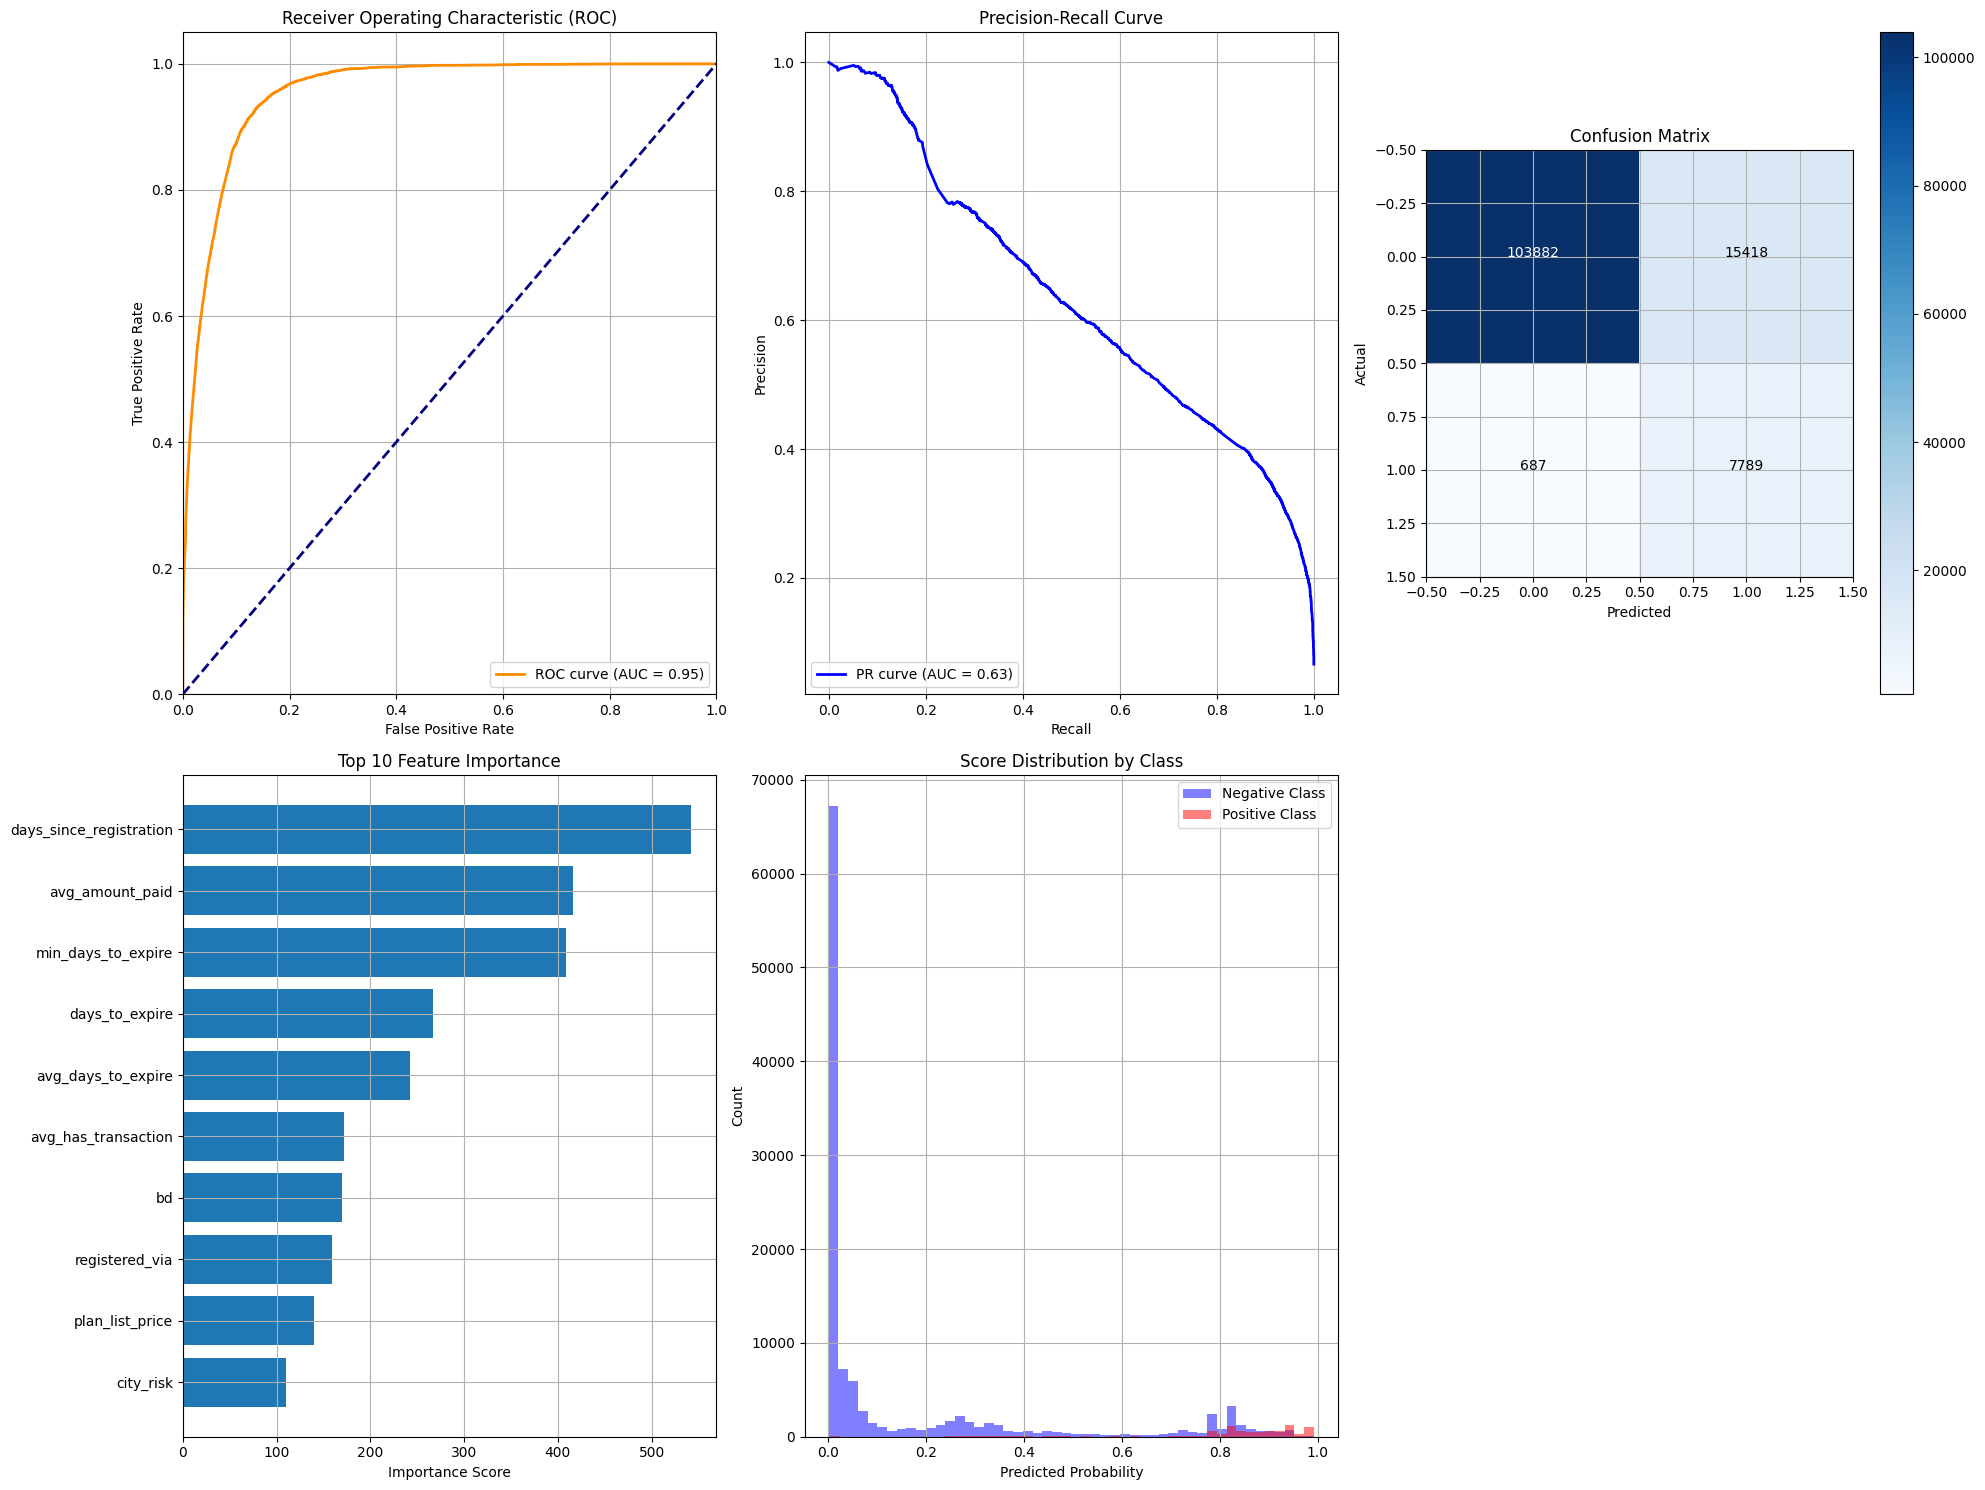


5. ANÁLISE DE THRESHOLDS:
------------------------------
 threshold  precision  recall     f1
       0.1     0.1943  0.9893 0.3248
       0.2     0.2142  0.9829 0.3517
       0.3     0.2636  0.9635 0.4140
       0.4     0.3081  0.9385 0.4640
       0.5     0.3356  0.9189 0.4917
       0.6     0.3503  0.9087 0.5057
       0.7     0.3658  0.8959 0.5195
       0.8     0.4375  0.7902 0.5632
       0.9     0.6688  0.4260 0.5205


In [ ]:
model, visualizer = run_complete_analysis(df_processed)


# Teste de abordagem balanceada


In [ ]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, precision_recall_curve, auc,
                           confusion_matrix, classification_report,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

class DataPreparator:
    def __init__(self, df):
        self.df = df.copy()
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='mean')

    def prepare_data(self, balance_data=True):
        """Prepara os dados para modelagem com tratamento de NaN"""
        # 1. Tratamento de valores faltantes categóricos
        self.df = self.df.fillna({
            'gender': 'unknown',
            'city_risk': 'medium',
            'payment_risk': 'medium'
        })

        # 2. Features categóricas para encoding
        categorical_features = ['gender', 'city_risk', 'payment_risk']

        # 3. Features numéricas para normalização
        numeric_features = [
            'days_since_registration', 'days_to_expire',
            'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
            'price_difference', 'payment_ratio',
            'avg_has_transaction', 'avg_auto_renew', 'avg_cancel',
            'avg_amount_paid', 'avg_days_to_expire',
            'min_days_to_expire', 'bd', 'registered_via'
        ]

        # 4. Label Encoding para features categóricas
        for feature in categorical_features:
            if feature in self.df.columns:
                le = LabelEncoder()
                self.df[feature] = le.fit_transform(self.df[feature].astype(str))
                self.label_encoders[feature] = le

        # 5. Tratamento de valores faltantes numéricos
        numeric_data = self.df[numeric_features].copy()
        self.df[numeric_features] = self.imputer.fit_transform(numeric_data)

        # 6. Normalização das features numéricas
        self.df[numeric_features] = self.scaler.fit_transform(self.df[numeric_features])

        # 7. Feature Engineering
        self.df['payment_efficiency'] = self.df['actual_amount_paid'] / (self.df['plan_list_price'] + 1)
        self.df['days_ratio'] = self.df['days_to_expire'] / (self.df['payment_plan_days'] + 1)

        # 8. Tratamento final de possíveis NaN
        self.df = self.df.fillna(0)

        # 9. Seleção final das features
        selected_features = numeric_features + categorical_features + ['payment_efficiency', 'days_ratio']
        X = self.df[selected_features].copy()
        y = self.df['churn']

        # 10. Verificação final de NaN
        assert X.isna().sum().sum() == 0, "Ainda existem valores NaN nos dados"

        return X, y

class EnhancedModelTrainer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best_threshold = None

    def train_model(self, balance_data=True):
        """Treina o modelo com validação cruzada e balanceamento opcional"""
        # Split inicial dos dados
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )

        # Aplicar SMOTE apenas nos dados de treino
        if balance_data:
            try:
                smote = SMOTE(random_state=42)
                X_train, y_train = smote.fit_resample(X_train, y_train)
            except Exception as e:
                print(f"Erro ao aplicar SMOTE: {e}")
                print("Continuando sem balanceamento...")

        # Configuração do modelo com parâmetros otimizados
        model = lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            boosting_type='gbdt',
            num_leaves=31,
            learning_rate=0.03,
            feature_fraction=0.8,
            n_estimators=200,
            class_weight='balanced',
            random_state=42
        )

        # Validação cruzada
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        print(f"\nValidação Cruzada - ROC-AUC médio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        # Treinar modelo final
        model.fit(X_train, y_train)

        # Encontrar melhor threshold
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        self.best_threshold = self.find_optimal_threshold(y_test, y_pred_proba)

        return model, X_train, X_test, y_train, y_test

    @staticmethod
    def find_optimal_threshold(y_true, y_pred_proba):
        """Encontra o threshold ótimo baseado na métrica F1"""
        thresholds = np.arange(0.1, 0.9, 0.1)
        best_f1 = 0
        best_threshold = 0.5

        for threshold in thresholds:
            y_pred = (y_pred_proba > threshold).astype(int)
            f1 = f1_score(y_true, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        return best_threshold

class EnhancedModelVisualizer:
    def __init__(self, model, X_train, X_test, y_train, y_test, best_threshold=0.5):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.best_threshold = best_threshold
        self.y_pred_proba = model.predict_proba(X_test)[:, 1]
        self.y_pred = (self.y_pred_proba > self.best_threshold).astype(int)

    def generate_performance_report(self):
        """Gera relatório completo de performance"""
        self.print_detailed_metrics()
        self.plot_all_metrics()

    def print_detailed_metrics(self):
        """Imprime métricas detalhadas"""
        print("\n" + "="*50)
        print("RELATÓRIO DETALHADO DE PERFORMANCE DO MODELO")
        print("="*50)

        print(f"\nThreshold utilizado: {self.best_threshold:.3f}")

        print("\n1. MÉTRICAS PRINCIPAIS:")
        print("-"*30)
        metrics = {
            "ROC-AUC": roc_auc_score(self.y_test, self.y_pred_proba),
            "Accuracy": accuracy_score(self.y_test, self.y_pred),
            "Precision": precision_score(self.y_test, self.y_pred),
            "Recall": recall_score(self.y_test, self.y_pred),
            "F1-Score": f1_score(self.y_test, self.y_pred)
        }

        for metric, value in metrics.items():
            print(f"{metric:15} : {value:.4f}")

        print("\n2. CLASSIFICATION REPORT:")
        print("-"*30)
        print(classification_report(self.y_test, self.y_pred))

        print("\n3. CONFUSION MATRIX:")
        print("-"*30)
        cm = confusion_matrix(self.y_test, self.y_pred)
        print("                 Predicted")
        print("                 Neg    Pos")
        print(f"Actual Neg    {cm[0,0]:6d} {cm[0,1]:6d}")
        print(f"      Pos    {cm[1,0]:6d} {cm[1,1]:6d}")

    def plot_all_metrics(self):
        """Plota todas as métricas relevantes"""
        plt.figure(figsize=(15, 10))

        # ROC Curve
        plt.subplot(2, 2, 1)
        self.plot_roc_curve()

        # Precision-Recall Curve
        plt.subplot(2, 2, 2)
        self.plot_precision_recall_curve()

        # Feature Importance
        plt.subplot(2, 2, 3)
        self.plot_feature_importance()

        # Score Distribution
        plt.subplot(2, 2, 4)
        self.plot_score_distribution()

        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")

    def plot_precision_recall_curve(self):
        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_proba)
        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, color='blue', lw=2,
                label=f'PR curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")

    def plot_feature_importance(self):
        importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=True)

        plt.barh(range(len(importance.importance[-10:])),
                importance.importance[-10:],
                align='center')
        plt.yticks(range(len(importance.importance[-10:])),
                  importance.feature[-10:])
        plt.xlabel('Importance Score')
        plt.title('Top 10 Feature Importance')

    def plot_score_distribution(self):
        plt.hist(self.y_pred_proba[self.y_test == 0], bins=50, alpha=0.5,
                label='Negative Class', color='blue')
        plt.hist(self.y_pred_proba[self.y_test == 1], bins=50, alpha=0.5,
                label='Positive Class', color='red')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Count')
        plt.title('Score Distribution by Class')
        plt.legend()

def run_enhanced_analysis(df):
    print("Iniciando análise aprimorada...")

    # 1. Preparar dados
    print("Preparando dados com features adicionais...")
    preparator = DataPreparator(df)
    X, y = preparator.prepare_data(balance_data=True)

    # 2. Treinar modelo
    print("Treinando modelo com validação cruzada...")
    trainer = EnhancedModelTrainer(X, y)
    model, X_train, X_test, y_train, y_test = trainer.train_model(balance_data=True)

    # 3. Visualização e relatórios
    print(f"Gerando relatório de performance (threshold = {trainer.best_threshold:.2f})...")
    visualizer = EnhancedModelVisualizer(model, X_train, X_test, y_train, y_test,
                                        best_threshold=trainer.best_threshold)
    visualizer.generate_performance_report()

    return model, visualizer, trainer.best_threshold

Iniciando análise aprimorada...
Preparando dados com features adicionais...
Treinando modelo com validação cruzada...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 381757, number of negative: 381756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3654
[LightGBM] [Info] Number of data points in the train set: 763513, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wi

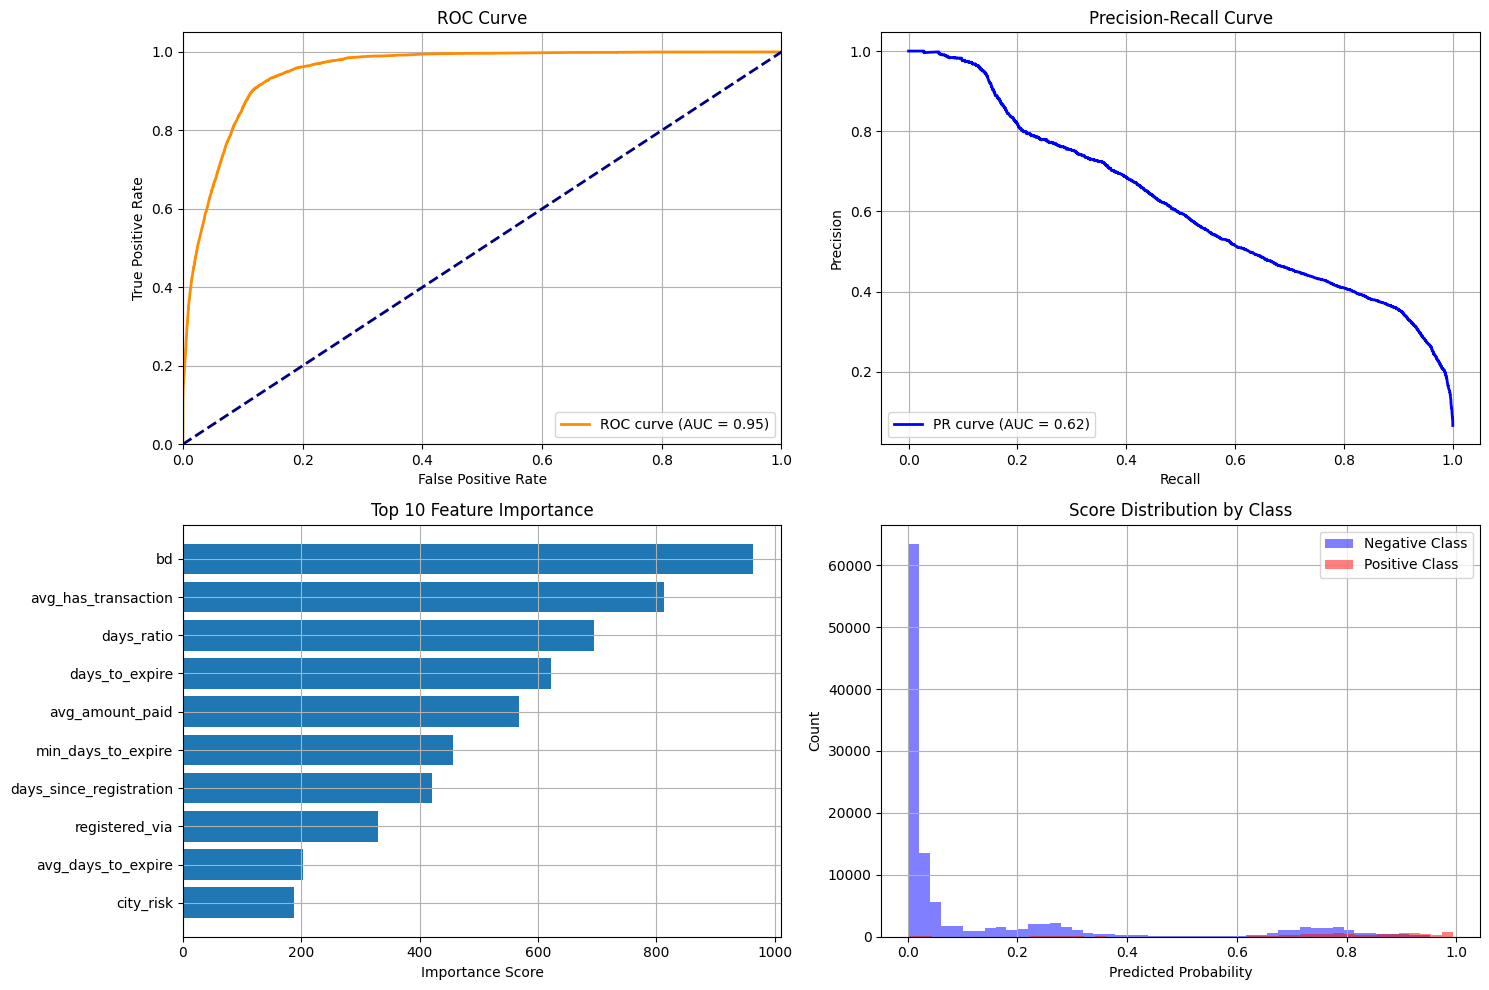

In [ ]:
model, visualizer, best_threshold = run_enhanced_analysis(df_processed)

# Análise Comparativa dos Modelos

## Principais Mudanças Implementadas
1. **Balanceamento de Classes**
   - Modelo Original: Classes muito desbalanceadas (93.37% vs 6.63%)
   - Novo Modelo: Classes balanceadas usando SMOTE (50% vs 50%)

2. **Feature Engineering**
   - Adição de novas features: 'payment_efficiency' e 'days_ratio'
   - Aumento de 18 para 20 features

3. **Hiperparâmetros**
   - Redução do learning rate de 0.05 para 0.03
   - Redução do feature_fraction de 0.9 para 0.8
   - Aumento do n_estimators de 100 para 200

## Comparação de Métricas

| Métrica    | Modelo Original | Novo Modelo | Variação |
|------------|----------------|-------------|-----------|
| ROC-AUC    | 0.9546        | 0.9507      | -0.0039   |
| Accuracy   | 0.8740        | 0.9398      | +0.0658   |
| Precision  | 0.3356        | 0.5457      | +0.2101   |
| Recall     | 0.9189        | 0.5562      | -0.3627   |
| F1-Score   | 0.4917        | 0.5509      | +0.0592   |

## Análise dos Resultados

### Pontos Positivos
1. **Melhor Equilíbrio**
   - Precision aumentou significativamente (+21%)
   - F1-Score melhorou (+5.92%)
   - Accuracy geral superior (+6.58%)

2. **Redução de Falsos Positivos**
   - Original: 15,418 falsos positivos
   - Novo: 3,925 falsos positivos
   - Redução de 74.5% nos falsos positivos

### Pontos de Atenção
1. **Redução do Recall**
   - Queda de 91.89% para 55.62%
   - Mais casos de churn podem passar despercebidos

2. **Trade-off Precision-Recall**
   - O modelo original era mais sensível (alto recall)
   - O novo modelo é mais preciso (alta precision)

## Implicações Práticas

1. **Modelo Original**
   - Melhor para situações onde perder um cliente é muito custoso
   - Gera mais falsos alarmes, mas perde poucos casos reais
   - Mais adequado para empresas com recursos para lidar com muitos alertas

2. **Novo Modelo**
   - Mais equilibrado e preciso nas previsões
   - Melhor para otimização de recursos
   - Mais adequado quando o custo de intervenção é alto

## Recomendações

1. **Escolha do Modelo**
   - Para alto custo de perda de cliente: Usar modelo original
   - Para otimização de recursos: Usar novo modelo

2. **Possíveis Melhorias**
   - Testar diferentes níveis de balanceamento
   - Explorar técnicas de ensemble combining
   - Ajustar threshold conforme necessidade específica do negócio

3. **Monitoramento**
   - Acompanhar custos de falsos positivos vs falsos negativos
   - Validar impacto financeiro das previsões
   - Ajustar modelo conforme evolução do negócio


## Problema

-  Maior importancia da feature bd que apresenta muitos zeros
-  Balanceamento das classes melhora as métricas especificas


In [ ]:
#print nomes das colunas de df_processed
print(df_processed.columns)

Index(['registration_init_time', 'city', 'bd', 'gender', 'registered_via',
       'is_ativo', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'is_ativo_futuro', 'churn',
       'has_transaction', 'days_since_registration', 'days_to_expire',
       'registration_month', 'registration_weekday', 'city_risk',
       'payment_risk', 'price_difference', 'payment_ratio',
       'avg_has_transaction', 'avg_auto_renew', 'avg_cancel',
       'avg_amount_paid', 'std_amount_paid', 'avg_days_to_expire',
       'min_days_to_expire'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

def prepare_features(df):
    """
    Prepara as features para o modelo, convertendo categóricas em numéricas
    """
    df_prep = df.copy()

    # Criando label encoders
    le_dict = {}
    categorical_columns = ['gender', 'city_risk', 'payment_risk']

    # Convertendo cada coluna categórica
    for col in categorical_columns:
        le_dict[col] = LabelEncoder()
        df_prep[col] = le_dict[col].fit_transform(df_prep[col].astype(str))

    return df_prep

# Lista de features para o modelo
model_features = [
    'days_since_registration',
    'days_to_expire',
    'payment_plan_days',
    'plan_list_price',
    'actual_amount_paid',
    'price_difference',
    'payment_ratio',
    'avg_has_transaction',
    'avg_auto_renew',
    'avg_cancel',
    'avg_amount_paid',
    'std_amount_paid',
    'avg_days_to_expire',
    'min_days_to_expire',
    'bd',
    'registered_via',
    'gender',
    'city_risk',
    'payment_risk',
    'is_auto_renew'
]

# Preparar os dados
df_model = prepare_features(df_processed)

# Separar features (X) e target (y)
X = df_model[model_features]
y = df_model['churn']

# Separar em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Parâmetros do modelo LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'n_estimators': 100,
    'random_state': 42
}

# Treinar o modelo
model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)

def create_score_dataframe(model, df_processed, threshold=0.5):
    """
    Cria um DataFrame com scores e informações relevantes para análise de churn.
    """
    # Preparar features
    df_model = prepare_features(df_processed)
    X_pred = df_model[model_features]

    # Calculando probabilidades
    probabilities = model.predict_proba(X_pred)

    # Criando DataFrame com scores
    df_scores = pd.DataFrame({
        'churn_probability': probabilities[:, 1],
        'churn_risk': np.where(probabilities[:, 1] > threshold, 1, 0),
        'real_churn': df_processed['churn'],
        'bd': df_processed['bd'],
        'days_to_expire': df_processed['days_to_expire'],
        'payment_plan_days': df_processed['payment_plan_days'],
        'plan_list_price': df_processed['plan_list_price'],
        'actual_amount_paid': df_processed['actual_amount_paid'],
        'payment_ratio': df_processed['payment_ratio']
    })

    # Criando categorias de risco
    df_scores['risk_category'] = pd.cut(
        df_scores['churn_probability'],
        bins=[0, 0.3, 0.6, 0.8, 1],
        labels=['Baixo Risco', 'Médio Risco', 'Alto Risco', 'Crítico']
    )

    # Calculando dias restantes normalizados
    df_scores['days_remaining_ratio'] = df_scores['days_to_expire'] / df_scores['payment_plan_days']

    # Ordenando por probabilidade de churn (descrescente)
    df_scores = df_scores.sort_values('churn_probability', ascending=False)

    # Adicionando rank percentual
    df_scores['risk_percentile'] = df_scores['churn_probability'].rank(pct=True) * 100

    # Criando flag para falsos positivos e negativos
    df_scores['prediction_type'] = np.where(
        (df_scores['churn_risk'] == 1) & (df_scores['real_churn'] == 1), 'True Positive',
        np.where(
            (df_scores['churn_risk'] == 1) & (df_scores['real_churn'] == 0), 'False Positive',
            np.where(
                (df_scores['churn_risk'] == 0) & (df_scores['real_churn'] == 1), 'False Negative',
                'True Negative'
            )
        )
    )

    # Adicionando informações financeiras
    df_scores['potential_loss'] = df_scores['plan_list_price'] * df_scores['churn_probability']

    return df_scores

def analyze_scores(df_scores):
    """
    Realiza análises no DataFrame de scores
    """
    print("\n=== ANÁLISE DE SCORES DE CHURN ===\n")

    # Distribuição por categoria de risco
    print("Distribuição por Categoria de Risco:")
    risk_dist = df_scores['risk_category'].value_counts(normalize=True).round(3) * 100
    print(risk_dist)

    # Média de probabilidade por BD
    print("\nMédia de Probabilidade de Churn por BD:")
    bd_prob = df_scores.groupby('bd')['churn_probability'].agg(['mean', 'count']).round(3)
    bd_prob.columns = ['Prob. Média de Churn', 'Quantidade']
    print(bd_prob)

    # Top 10 casos mais críticos
    print("\nTop 10 Casos Mais Críticos:")
    critical_cases = df_scores.nlargest(10, 'churn_probability')[
        ['churn_probability', 'bd', 'days_remaining_ratio', 'potential_loss']
    ]
    print(critical_cases)

    # Distribuição de previsões
    print("\nDistribuição de Tipos de Previsão:")
    pred_dist = df_scores['prediction_type'].value_counts(normalize=True).round(3) * 100
    print(pred_dist)

    # Análise financeira por categoria de risco
    print("\nAnálise Financeira por Categoria de Risco:")
    risk_finance = df_scores.groupby('risk_category').agg({
        'potential_loss': ['sum', 'mean', 'count']
    }).round(2)
    risk_finance.columns = ['Perda Total', 'Perda Média', 'Quantidade']
    print(risk_finance)

    return critical_cases

def generate_additional_stats(df_scores):
    """
    Gera estatísticas adicionais sobre os scores
    """
    print("\n=== Estatísticas Adicionais ===")
    print("\nMédia de probabilidade de churn:", df_scores['churn_probability'].mean().round(3))
    print("Mediana de probabilidade de churn:", df_scores['churn_probability'].median().round(3))
    print("Desvio padrão de probabilidade de churn:", df_scores['churn_probability'].std().round(3))

    print("\nAnálise por Quartis de Probabilidade:")
    quartis = df_scores['churn_probability'].quantile([0.25, 0.5, 0.75]).round(3)
    print(quartis)

    print("\nCorrelações com Probabilidade de Churn:")
    correlations = df_scores[['churn_probability', 'days_remaining_ratio', 'payment_ratio', 'plan_list_price']].corr()['churn_probability'].round(3)
    print(correlations)

# Avaliar o modelo
y_pred = model.predict(X_test)
print("\n=== Avaliação do Modelo ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Executar análise de scores
try:
    # Criar DataFrame de scores
    df_scores = create_score_dataframe(model, df_processed, threshold=0.5)

    # Realizar análises
    critical_cases = analyze_scores(df_scores)

    # Gerar estatísticas adicionais
    generate_additional_stats(df_scores)

    # Salvar resultados
    df_scores.to_csv('churn_scores.csv', index=False)
    print("\nResultados salvos com sucesso em 'churn_scores.csv'")

except Exception as e:
    print(f"Erro durante a execução: {str(e)}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 33906, number of negative: 477196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 511102, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066339 -> initscore=-2.644335
[LightGBM] [Info] Start training from score -2.644335
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9

=== Avaliação do Modelo ===

Classification Report:
              p

# Cluster em K-means


1. Preparando dados para clustering...

Verificação de valores nulos após limpeza:
churn_probability       0
days_remaining_ratio    0
payment_ratio           0
avg_amount_paid         0
avg_has_transaction     0
avg_auto_renew          0
avg_cancel              0
std_amount_paid         0
dtype: int64

Estatísticas básicas após limpeza:
       churn_probability  days_remaining_ratio  payment_ratio  \
count         638878.000            638878.000       638878.0   
mean               0.066                 1.579            1.0   
std                0.152                 0.227            0.0   
min                0.001                -0.976            1.0   
25%                0.001                 1.567            1.0   
50%                0.002                 1.567            1.0   
75%                0.029                 1.567            1.0   
max                0.975                 4.471            1.0   

       avg_amount_paid  avg_has_transaction  avg_auto_renew  avg_cancel  \

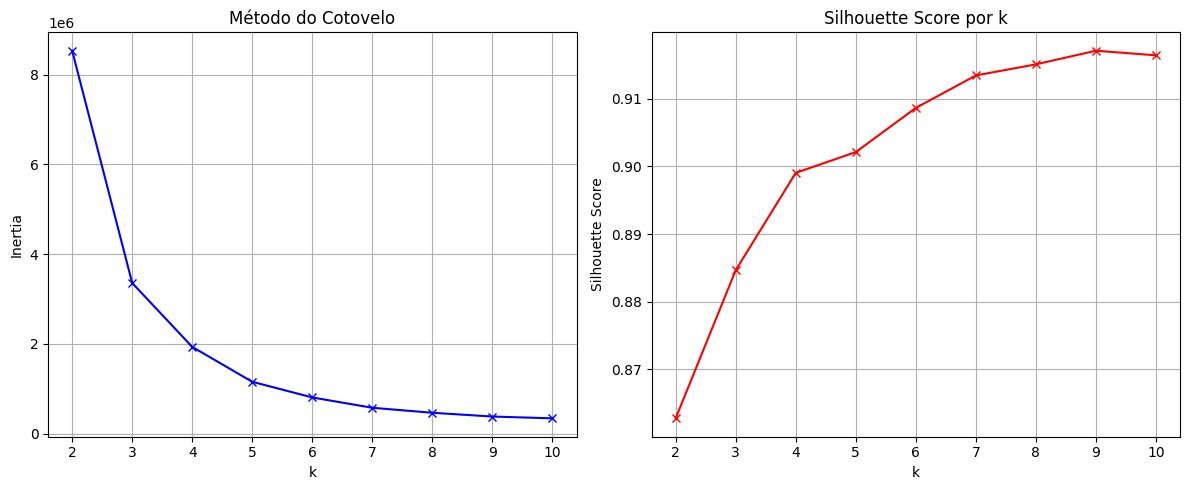

Número ótimo de clusters: 9

4. Aplicando K-means com número ótimo de clusters...

5. Analisando clusters...

=== Análise Estatística por Cluster ===
        churn_probability                      days_remaining_ratio         \
                     mean    std    min    max                 mean    std   
Cluster                                                                      
0                   0.261  0.124  0.004  0.764                1.517  0.231   
1                   0.012  0.074  0.001  0.975                1.575  0.148   
2                   0.299  0.153  0.039  0.958                1.491  0.306   
3                   0.337  0.218  0.019  0.919                1.727  0.520   
4                   0.256  0.129  0.005  0.731                1.523  0.185   
5                   0.267  0.080  0.050  0.959                1.612  0.375   
6                   0.299  0.138  0.031  0.847                1.572  0.520   
7                   0.203  0.295  0.019  0.968                1.574  0

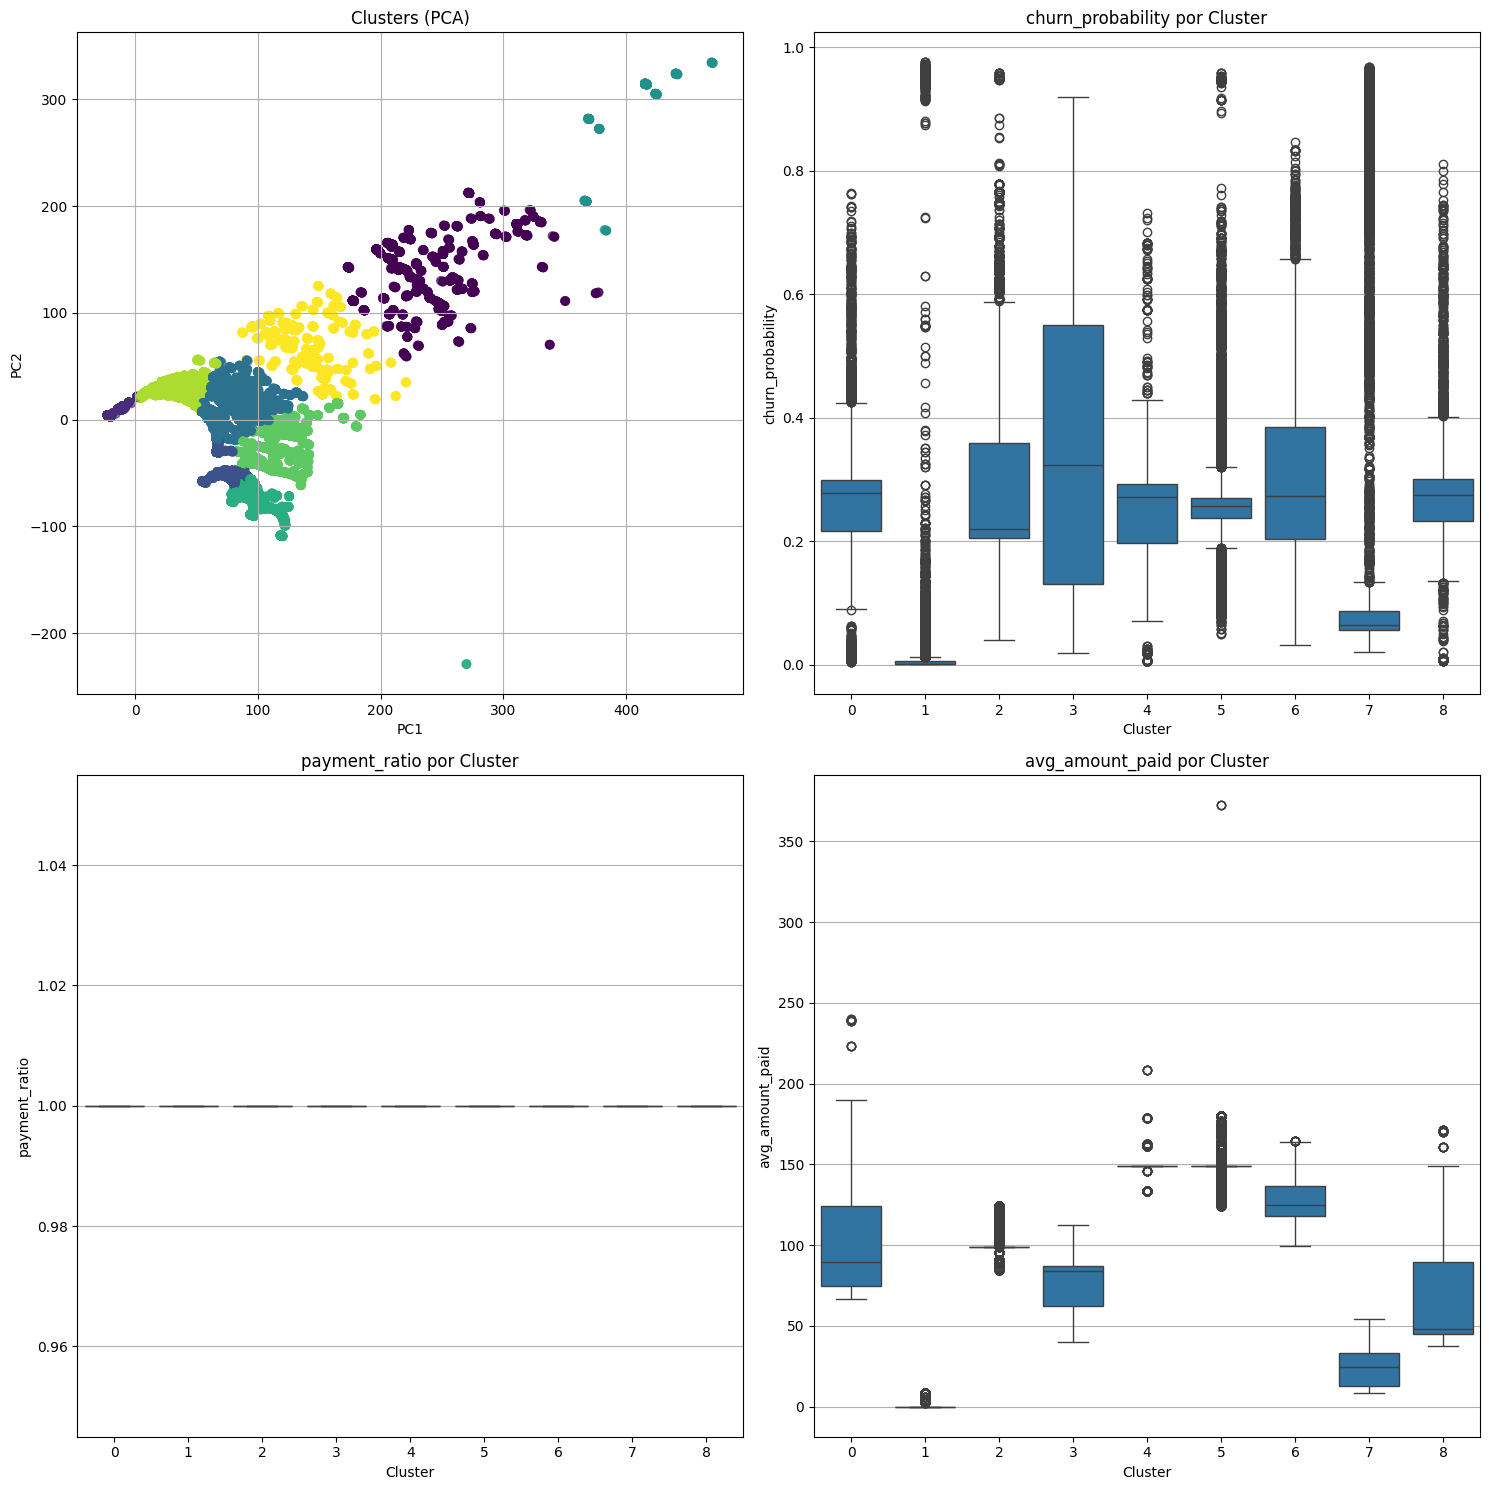

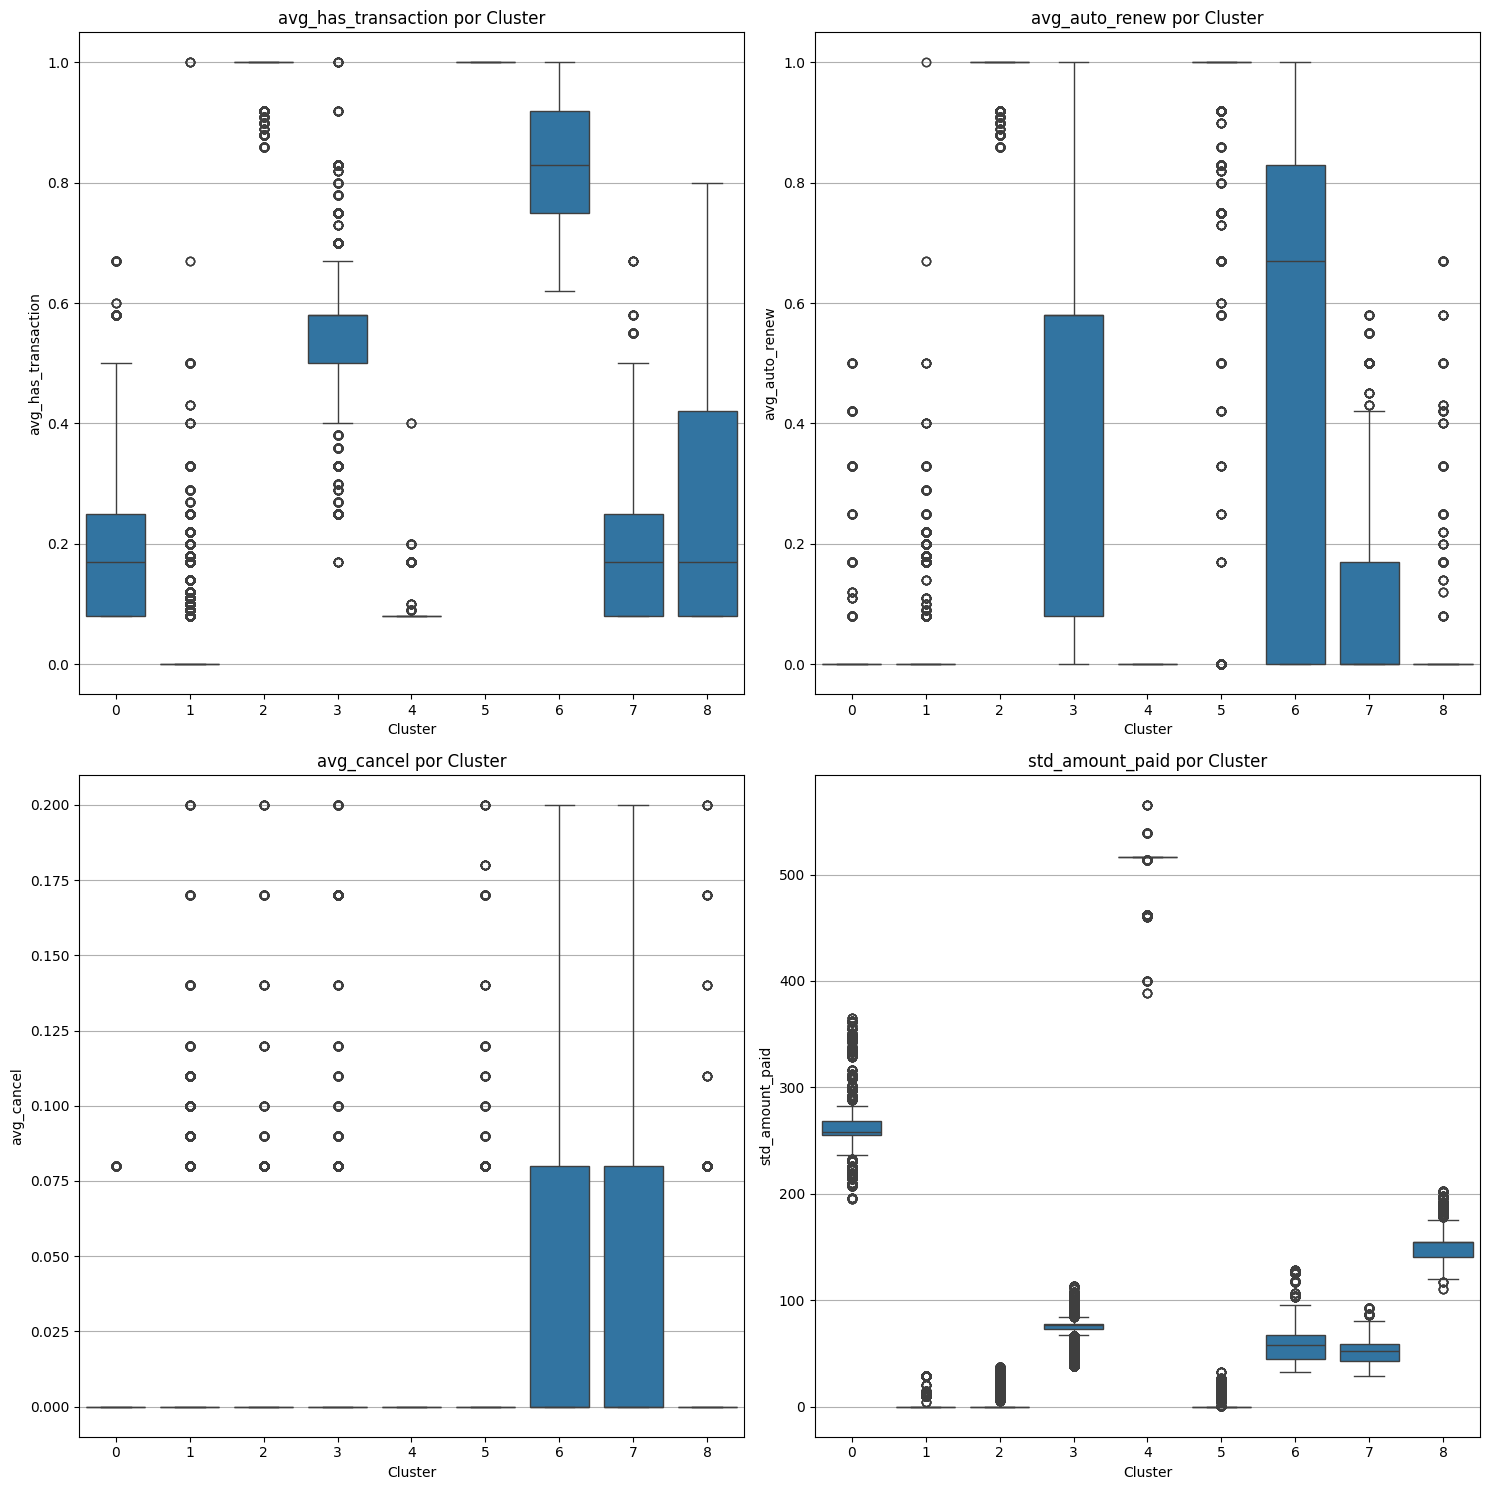


Resultados salvos em 'cluster_analysis_detailed.csv'


In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

def prepare_clustering_features(df_scores, df_processed):
    """
    Prepara e limpa as features para clustering de forma otimizada
    """
    # Selecionar features diretamente
    cluster_features = {
        'churn_probability': df_scores['churn_probability'],
        'days_remaining_ratio': df_scores['days_remaining_ratio'],
        'payment_ratio': df_scores['payment_ratio'],
        'avg_amount_paid': df_processed['avg_amount_paid'],
        'avg_has_transaction': df_processed['avg_has_transaction'],
        'avg_auto_renew': df_processed['avg_auto_renew'],
        'avg_cancel': df_processed['avg_cancel'],
        'std_amount_paid': df_processed['std_amount_paid']
    }

    # Criar DataFrame e converter para float32
    df_cluster = pd.DataFrame(cluster_features).astype(np.float32)

    # Tratamento de dados vetorizado
    df_cluster = df_cluster.replace([np.inf, -np.inf], np.nan)

    # Imputar valores nulos
    imputer = SimpleImputer(strategy='median')
    df_cluster_imputed = pd.DataFrame(
        imputer.fit_transform(df_cluster),
        columns=df_cluster.columns
    )

    # Remover outliers vetorizado
    Q1 = df_cluster_imputed.quantile(0.01)
    Q3 = df_cluster_imputed.quantile(0.99)
    IQR = Q3 - Q1
    df_cluster_imputed = df_cluster_imputed.clip(
        lower=Q1 - 1.5*IQR,
        upper=Q3 + 1.5*IQR,
        axis=1
    )

    print("\nVerificação de valores nulos após limpeza:")
    print(df_cluster_imputed.isnull().sum())

    print("\nEstatísticas básicas após limpeza:")
    print(df_cluster_imputed.describe().round(3))

    return df_cluster_imputed

def compute_metrics(k, X_scaled):
    """
    Computa métricas para um determinado número de clusters
    """
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=200)
    kmeans.fit(X_scaled)
    return (kmeans.inertia_, silhouette_score(X_scaled, kmeans.labels_))

def find_optimal_clusters(X_scaled, max_clusters=10, sample_size=5000):
    """
    Encontra o número ótimo de clusters usando processamento paralelo
    """
    # Usar amostra se o dataset for muito grande
    if len(X_scaled) > sample_size:
        idx = np.random.choice(len(X_scaled), sample_size, replace=False)
        X_sample = X_scaled[idx]
    else:
        X_sample = X_scaled

    # Computação paralela
    k_values = range(2, max_clusters+1)
    results = Parallel(n_jobs=-1)(
        delayed(compute_metrics)(k, X_sample) for k in k_values
    )

    inertias, silhouette_scores = zip(*results)

    # Plot resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Método do Cotovelo')

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'rx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score por k')

    plt.tight_layout()
    plt.show()

    return k_values[np.argmax(silhouette_scores)]

def analyze_clusters(df_cluster, clusters):
    """
    Análise detalhada dos clusters
    """
    df_analysis = df_cluster.copy()
    df_analysis['Cluster'] = clusters

    print("\n=== Análise Estatística por Cluster ===")
    cluster_stats = df_analysis.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats.round(3))

    print("\n=== Tamanho dos Clusters ===")
    cluster_sizes = df_analysis['Cluster'].value_counts().sort_index()
    print(cluster_sizes)

    return df_analysis

def visualize_clusters_detailed(X_scaled, clusters, df_analysis):
    """
    Visualização otimizada dos clusters
    """
    # PCA para visualização
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Criar visualizações eficientes
    fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=100)
    axes = axes.ravel()

    # 1. Scatter plot PCA
    scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    axes[0].set_title('Clusters (PCA)')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')

    # 2-4. Features importantes
    features = ['churn_probability', 'payment_ratio', 'avg_amount_paid']
    for i, feature in enumerate(features, 1):
        sns.boxplot(x='Cluster', y=feature, data=df_analysis, ax=axes[i])
        axes[i].set_title(f'{feature} por Cluster')

    plt.tight_layout()
    plt.show()

    # Plot adicional para outras features
    fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=100)
    axes = axes.ravel()

    features = ['avg_has_transaction', 'avg_auto_renew', 'avg_cancel', 'std_amount_paid']
    for i, feature in enumerate(features):
        sns.boxplot(x='Cluster', y=feature, data=df_analysis, ax=axes[i])
        axes[i].set_title(f'{feature} por Cluster')

    plt.tight_layout()
    plt.show()

def run_cluster_analysis(df_scores, df_processed):
    try:
        print("1. Preparando dados para clustering...")
        df_cluster = prepare_clustering_features(df_scores, df_processed)

        print("\n2. Normalizando dados...")
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df_cluster)

        print("\nVerificação após normalização:")
        print("Shape:", X_scaled.shape)
        print("Contém NaN:", np.isnan(X_scaled).any())
        print("Contém Inf:", np.isinf(X_scaled).any())

        print("\n3. Encontrando número ótimo de clusters...")
        optimal_k = find_optimal_clusters(X_scaled, max_clusters=10, sample_size=5000)
        print(f"Número ótimo de clusters: {optimal_k}")

        print("\n4. Aplicando K-means com número ótimo de clusters...")
        kmeans = KMeans(
            n_clusters=optimal_k,
            random_state=42,
            n_init=5,
            max_iter=200
        )
        clusters = kmeans.fit_predict(X_scaled)

        print("\n5. Analisando clusters...")
        df_analysis = analyze_clusters(df_cluster, clusters)

        print("\n6. Gerando visualizações...")
        visualize_clusters_detailed(X_scaled, clusters, df_analysis)

        # Adicionar clusters ao DataFrame original
        df_cluster['Cluster'] = clusters

        # Salvar resultados
        df_cluster.to_csv('cluster_analysis_detailed.csv', index=False)
        print("\nResultados salvos em 'cluster_analysis_detailed.csv'")

        return df_analysis, clusters, kmeans

    except Exception as e:
        print(f"\nErro durante a execução: {str(e)}")
        print("\nTraceback completo:")
        import traceback
        traceback.print_exc()
        return None, None, None

# Para executar a análise
if __name__ == "__main__":
    # Assumindo que df_scores e df_processed já estão carregados
    df_analysis, clusters, kmeans_model = run_cluster_analysis(df_scores, df_processed)

# Estratégia de negócios com GEN AI


In [ ]:
!pip install groq

In [66]:
from groq import Groq
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

def criar_perfil_cluster(df_analysis, cluster_num):
    """
    Cria um perfil detalhado para cada cluster com análises expandidas
    """
    cluster_data = df_analysis[df_analysis['Cluster'] == cluster_num]

    # Análises básicas
    perfil = {
        'tamanho': len(cluster_data),
        'prob_churn': cluster_data['churn_probability'].mean(),
        'razao_pagamento': cluster_data['payment_ratio'].mean(),
        'valor_medio': cluster_data['avg_amount_paid'].mean(),
        'freq_transacao': cluster_data['avg_has_transaction'].mean(),
        'auto_renovacao': cluster_data['avg_auto_renew'].mean(),
        'valor_risco': len(cluster_data) * cluster_data['avg_amount_paid'].mean() * cluster_data['churn_probability'].mean(),

        # Análises adicionais
        'desvio_pagamento': cluster_data['payment_ratio'].std(),
        'percentil_75_valor': cluster_data['avg_amount_paid'].quantile(0.75),
        'percentil_25_valor': cluster_data['avg_amount_paid'].quantile(0.25),
        'clientes_alto_risco': len(cluster_data[cluster_data['churn_probability'] > 0.7]),
        'clientes_baixo_risco': len(cluster_data[cluster_data['churn_probability'] < 0.3]),
        'valor_medio_alto_risco': cluster_data[cluster_data['churn_probability'] > 0.7]['avg_amount_paid'].mean()
    }

    return perfil

def gerar_calendario_lancamentos(client, perfil_cluster, cluster_num):
    """
    Gera um calendário detalhado de lançamentos com recomendações específicas
    """
    prompt = f"""
    Analise o seguinte perfil de cluster e crie um plano estratégico detalhado:

    PERFIL DO CLUSTER {cluster_num}:
    Métricas Principais:
    - Base: {perfil_cluster['tamanho']} clientes
    - Churn Médio: {perfil_cluster['prob_churn']:.2%}
    - Ticket Médio: R${perfil_cluster['valor_medio']:.2f}
    - Frequência de Transações: {perfil_cluster['freq_transacao']:.2f}

    Análises Avançadas:
    - Clientes Alto Risco: {perfil_cluster['clientes_alto_risco']} ({(perfil_cluster['clientes_alto_risco']/perfil_cluster['tamanho'])*100:.1f}%)
    - Valor em Risco Total: R${perfil_cluster['valor_risco']:,.2f}
    - Dispersão de Pagamentos: {perfil_cluster['desvio_pagamento']:.2f}
    - Range de Valores: R${perfil_cluster['percentil_25_valor']:.2f} - R${perfil_cluster['percentil_75_valor']:.2f}

    Por favor, desenvolva:

    1. PLANO DE AÇÃO MENSAL (próximos 6 meses):
       - Ações específicas por mês
       - Gatilhos de comunicação
       - Metas quantitativas

    2. ESTRATÉGIA DE OFERTAS:
       - Segmentação por risco
       - Propostas de valor
       - Mecânicas promocionais

    3. RECOMENDAÇÕES DE ENGAJAMENTO:
       - Pontos de contato
       - Conteúdo sugerido
       - Momentos críticos

    4. METAS E KPIS:
       - Redução de churn esperada
       - Aumento de receita projetado
       - Métricas de acompanhamento

    5. ORÇAMENTO E RECURSOS:
       - Investimento sugerido
       - Alocação de recursos
       - ROI esperado

    Forneça recomendações práticas e acionáveis, com números e prazos específicos.
    """

    completion = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=2048,
        stream=True
    )

    response = ""
    for chunk in completion:
        response += (chunk.choices[0].delta.content or "")

    return response

def simular_impacto_financeiro(perfil_cluster, cenarios):
    """
    Simula o impacto financeiro com análises expandidas
    """
    base_revenue = perfil_cluster['tamanho'] * perfil_cluster['valor_medio'] * 12

    resultados = {
        'cenario_base': {
            'receita_anual': base_revenue,
            'churn_rate': perfil_cluster['prob_churn'],
            'clientes_retidos': perfil_cluster['tamanho'] * (1 - perfil_cluster['prob_churn']),
            'valor_risco_anual': perfil_cluster['valor_risco'] * 12,
            'receita_por_cliente': perfil_cluster['valor_medio'] * 12
        }
    }

    for cenario, params in cenarios.items():
        nova_receita = base_revenue * (1 + params['aumento_receita'])
        novo_churn = perfil_cluster['prob_churn'] * (1 - params['reducao_churn'])
        custo_implementacao = perfil_cluster['tamanho'] * params['custo_por_cliente']

        resultados[cenario] = {
            'receita_anual': nova_receita,
            'churn_rate': novo_churn,
            'clientes_retidos': perfil_cluster['tamanho'] * (1 - novo_churn),
            'custo_implementacao': custo_implementacao,
            'roi': (nova_receita - base_revenue) / custo_implementacao if custo_implementacao > 0 else 0,
            'payback_meses': (custo_implementacao / ((nova_receita - base_revenue) / 12)) if (nova_receita - base_revenue) > 0 else float('inf'),
            'economia_churn': perfil_cluster['valor_risco'] * params['reducao_churn'] * 12,
            'receita_incremental': nova_receita - base_revenue
        }

    return resultados

def gerar_relatorio_impacto(client, perfil_cluster, resultados_simulacao):
    """
    Gera um relatório detalhado de análise de impacto com recomendações específicas
    """
    prompt = f"""
    Analise detalhadamente os seguintes resultados e forneça recomendações estratégicas:

    SITUAÇÃO ATUAL:
    Base de Clientes: {perfil_cluster['tamanho']} clientes
    Receita Anual: R${resultados_simulacao['cenario_base']['receita_anual']:,.2f}
    Churn Atual: {resultados_simulacao['cenario_base']['churn_rate']:.2%}
    Valor em Risco Anual: R${resultados_simulacao['cenario_base']['valor_risco_anual']:,.2f}

    ANÁLISE DOS CENÁRIOS:
    Conservador:
    - ROI: {resultados_simulacao['conservador']['roi']:.2%}
    - Payback: {resultados_simulacao['conservador']['payback_meses']:.1f} meses
    - Economia em Churn: R${resultados_simulacao['conservador']['economia_churn']:,.2f}

    Moderado:
    - ROI: {resultados_simulacao['moderado']['roi']:.2%}
    - Payback: {resultados_simulacao['moderado']['payback_meses']:.1f} meses
    - Economia em Churn: R${resultados_simulacao['moderado']['economia_churn']:,.2f}

    Agressivo:
    - ROI: {resultados_simulacao['agressivo']['roi']:.2%}
    - Payback: {resultados_simulacao['agressivo']['payback_meses']:.1f} meses
    - Economia em Churn: R${resultados_simulacao['agressivo']['economia_churn']:,.2f}

    Por favor, forneça:

    1. ANÁLISE ESTRATÉGICA:
       - Avaliação detalhada de cada cenário
       - Principais oportunidades identificadas
       - Riscos e pontos de atenção
       - Cenário recomendado com justificativa

    2. PLANO DE IMPLEMENTAÇÃO:
       - Etapas detalhadas
       - Timeline sugerido
       - Recursos necessários
       - Pontos críticos de sucesso

    3. MÉTRICAS DE ACOMPANHAMENTO:
       - KPIs principais
       - Metas por etapa
       - Gatilhos de ajuste
       - Indicadores de sucesso

    4. RECOMENDAÇÕES ESPECÍFICAS:
       - Ações prioritárias
       - Abordagem por segmento
       - Estratégias de comunicação
       - Pontos de otimização

    5. ANÁLISE FINANCEIRA:
       - Detalhamento do investimento
       - Projeção de retorno
       - Análise de sensibilidade
       - Pontos de equilíbrio

    Forneça uma análise objetiva e acionável, com recomendações práticas e métricas claras.
    """

    completion = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=2048,
        stream=True
    )

    response = ""
    for chunk in completion:
        response += (chunk.choices[0].delta.content or "")

    return response

def implementar_estrategia_completa(df_analysis, api_key):
    """
    Implementa o workflow completo com análises expandidas
    """
    client = Groq(api_key=api_key)
    clusters = df_analysis['Cluster'].unique()
    resultados_completos = {}

    for cluster in clusters:
        print(f"\n=== Iniciando Análise Detalhada do Cluster {cluster} ===")

        # Criar perfil expandido do cluster
        perfil = criar_perfil_cluster(df_analysis, cluster)
        print(f"\nPerfil do Cluster {cluster} criado com {perfil['tamanho']} clientes")

        # Gerar calendário detalhado
        print("Gerando plano estratégico...")
        calendario = gerar_calendario_lancamentos(client, perfil, cluster)

        # Definir cenários com parâmetros ajustados
        cenarios = {
            'conservador': {
                'aumento_receita': 0.05,
                'reducao_churn': 0.10,
                'custo_por_cliente': 50
            },
            'moderado': {
                'aumento_receita': 0.15,
                'reducao_churn': 0.25,
                'custo_por_cliente': 100
            },
            'agressivo': {
                'aumento_receita': 0.30,
                'reducao_churn': 0.40,
                'custo_por_cliente': 200
            }
        }

        # Simular impacto financeiro detalhado
        print("Realizando simulações financeiras...")
        simulacao = simular_impacto_financeiro(perfil, cenarios)

        # Gerar relatório completo
        print("Gerando relatório de recomendações...")
        relatorio = gerar_relatorio_impacto(client, perfil, simulacao)

        resultados_completos[cluster] = {
            'perfil': perfil,
            'calendario': calendario,
            'simulacao': simulacao,
            'relatorio': relatorio
        }

        # Salvar resultados detalhados
        with open(f'estrategia_detalhada_cluster_{cluster}.txt', 'w', encoding='utf-8') as f:
            f.write(f"=== ANÁLISE ESTRATÉGICA DETALHADA - CLUSTER {cluster} ===\n\n")
            f.write("=== 1. PERFIL DO CLUSTER ===\n")
            for k, v in perfil.items():
                f.write(f"{k}: {v}\n")
            f.write("\n=== 2. PLANO ESTRATÉGICO ===\n")
            f.write(calendario)
            f.write("\n=== 3. SIMULAÇÕES FINANCEIRAS ===\n")
            for cenario, resultados in simulacao.items():
                f.write(f"\n{cenario.upper()}:\n")
                for k, v in resultados.items():
                    f.write(f"{k}: {v}\n")
            f.write("\n=== 4. RECOMENDAÇÕES E PRÓXIMOS PASSOS ===\n")
            f.write(relatorio)

        print(f"Análise do Cluster {cluster} concluída e salva!")

    return resultados_completos

# Executar a análise completa
try:
    GROQ_API_KEY = "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"
    resultados = implementar_estrategia_completa(df_analysis, GROQ_API_KEY)

    print("\n=== DASHBOARD DE RESULTADOS ===")
    for cluster, dados in resultados.items():
        print(f"\nCLUSTER {cluster}:")
        print(f"Base de Clientes: {dados['perfil']['tamanho']:,}")
        print(f"Valor em Risco Anual: R${dados['perfil']['valor_risco']*12:,.2f}")
        print(f"ROI Esperado (Cenário Moderado): {dados['simulacao']['moderado']['roi']:.2%}")
        print(f"Payback (Meses): {dados['simulacao']['moderado']['payback_meses']:.1f}")
        print(f"Clientes Alto Risco: {dados['perfil']['clientes_alto_risco']} ({dados['perfil']['clientes_alto_risco']/dados['perfil']['tamanho']*100:.1f}%)")

except Exception as e:
    print(f"Erro durante a execução: {str(e)}")
    import traceback
    traceback.print_exc()


=== Iniciando Análise Detalhada do Cluster 5 ===

Perfil do Cluster 5 criado com 35159 clientes
Gerando plano estratégico...
Realizando simulações financeiras...
Gerando relatório de recomendações...
Análise do Cluster 5 concluída e salva!

=== Iniciando Análise Detalhada do Cluster 1 ===

Perfil do Cluster 1 criado com 508692 clientes
Gerando plano estratégico...
Realizando simulações financeiras...
Gerando relatório de recomendações...
Análise do Cluster 1 concluída e salva!

=== Iniciando Análise Detalhada do Cluster 3 ===

Perfil do Cluster 3 criado com 27376 clientes
Gerando plano estratégico...
Realizando simulações financeiras...
Gerando relatório de recomendações...
Análise do Cluster 3 concluída e salva!

=== Iniciando Análise Detalhada do Cluster 0 ===

Perfil do Cluster 0 criado com 5927 clientes
Gerando plano estratégico...
Realizando simulações financeiras...
Gerando relatório de recomendações...
Análise do Cluster 0 concluída e salva!

=== Iniciando Análise Detalhada do 

In [67]:
from groq import Groq
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

def criar_perfil_cluster(df_analysis, cluster_num):
    """
    Cria um perfil detalhado para cada cluster com análises expandidas
    """
    cluster_data = df_analysis[df_analysis['Cluster'] == cluster_num]

    perfil = {
        'tamanho': len(cluster_data),
        'prob_churn': cluster_data['churn_probability'].mean(),
        'razao_pagamento': cluster_data['payment_ratio'].mean(),
        'valor_medio': cluster_data['avg_amount_paid'].mean(),
        'freq_transacao': cluster_data['avg_has_transaction'].mean(),
        'auto_renovacao': cluster_data['avg_auto_renew'].mean(),
        'valor_risco': len(cluster_data) * cluster_data['avg_amount_paid'].mean() * cluster_data['churn_probability'].mean(),
        'desvio_pagamento': cluster_data['payment_ratio'].std(),
        'percentil_75_valor': cluster_data['avg_amount_paid'].quantile(0.75),
        'percentil_25_valor': cluster_data['avg_amount_paid'].quantile(0.25),
        'clientes_alto_risco': len(cluster_data[cluster_data['churn_probability'] > 0.7]),
        'clientes_baixo_risco': len(cluster_data[cluster_data['churn_probability'] < 0.3]),
        'valor_medio_alto_risco': cluster_data[cluster_data['churn_probability'] > 0.7]['avg_amount_paid'].mean()
    }

    return perfil

def gerar_calendario_lancamentos(client, perfil_cluster, cluster_num):
    """
    Gera um calendário detalhado de lançamentos com recomendações específicas
    """
    prompt = f"""
    Analise o seguinte perfil de cluster e crie um plano estratégico detalhado:

    PERFIL DO CLUSTER {cluster_num}:
    Métricas Principais:
    - Base: {perfil_cluster['tamanho']} clientes
    - Churn Médio: {perfil_cluster['prob_churn']:.2%}
    - Ticket Médio: R${perfil_cluster['valor_medio']:.2f}
    - Frequência de Transações: {perfil_cluster['freq_transacao']:.2f}

    Análises Avançadas:
    - Clientes Alto Risco: {perfil_cluster['clientes_alto_risco']} ({(perfil_cluster['clientes_alto_risco']/perfil_cluster['tamanho'])*100:.1f}%)
    - Valor em Risco Total: R${perfil_cluster['valor_risco']:,.2f}
    - Dispersão de Pagamentos: {perfil_cluster['desvio_pagamento']:.2f}
    - Range de Valores: R${perfil_cluster['percentil_25_valor']:.2f} - R${perfil_cluster['percentil_75_valor']:.2f}

    Por favor, desenvolva:

    1. PLANO DE AÇÃO MENSAL (próximos 6 meses):
       - Ações específicas por mês
       - Gatilhos de comunicação
       - Metas quantitativas

    2. ESTRATÉGIA DE OFERTAS:
       - Segmentação por risco
       - Propostas de valor
       - Mecânicas promocionais

    3. RECOMENDAÇÕES DE ENGAJAMENTO:
       - Pontos de contato
       - Conteúdo sugerido
       - Momentos críticos

    4. METAS E KPIS:
       - Redução de churn esperada
       - Aumento de receita projetado
       - Métricas de acompanhamento

    5. ORÇAMENTO E RECURSOS:
       - Investimento sugerido
       - Alocação de recursos
       - ROI esperado

    Forneça recomendações práticas e acionáveis, com números e prazos específicos.
    """

    completion = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=2048,
        stream=True
    )

    response = ""
    for chunk in completion:
        response += (chunk.choices[0].delta.content or "")

    return response

def simular_impacto_financeiro(perfil_cluster, cenarios):
    """
    Simula o impacto financeiro com análises expandidas
    """
    base_revenue = perfil_cluster['tamanho'] * perfil_cluster['valor_medio'] * 12

    resultados = {
        'cenario_base': {
            'receita_anual': base_revenue,
            'churn_rate': perfil_cluster['prob_churn'],
            'clientes_retidos': perfil_cluster['tamanho'] * (1 - perfil_cluster['prob_churn']),
            'valor_risco_anual': perfil_cluster['valor_risco'] * 12,
            'receita_por_cliente': perfil_cluster['valor_medio'] * 12
        }
    }

    for cenario, params in cenarios.items():
        nova_receita = base_revenue * (1 + params['aumento_receita'])
        novo_churn = perfil_cluster['prob_churn'] * (1 - params['reducao_churn'])
        custo_implementacao = perfil_cluster['tamanho'] * params['custo_por_cliente']

        resultados[cenario] = {
            'receita_anual': nova_receita,
            'churn_rate': novo_churn,
            'clientes_retidos': perfil_cluster['tamanho'] * (1 - novo_churn),
            'custo_implementacao': custo_implementacao,
            'roi': (nova_receita - base_revenue) / custo_implementacao if custo_implementacao > 0 else 0,
            'payback_meses': (custo_implementacao / ((nova_receita - base_revenue) / 12)) if (nova_receita - base_revenue) > 0 else float('inf'),
            'economia_churn': perfil_cluster['valor_risco'] * params['reducao_churn'] * 12,
            'receita_incremental': nova_receita - base_revenue
        }

    return resultados

def gerar_relatorio_impacto(client, perfil_cluster, resultados_simulacao):
    """
    Gera um relatório detalhado de análise de impacto com recomendações específicas
    """
    prompt = f"""
    Analise detalhadamente os seguintes resultados e forneça recomendações estratégicas:

    SITUAÇÃO ATUAL:
    Base de Clientes: {perfil_cluster['tamanho']} clientes
    Receita Anual: R${resultados_simulacao['cenario_base']['receita_anual']:,.2f}
    Churn Atual: {resultados_simulacao['cenario_base']['churn_rate']:.2%}
    Valor em Risco Anual: R${resultados_simulacao['cenario_base']['valor_risco_anual']:,.2f}

    ANÁLISE DOS CENÁRIOS:
    Conservador:
    - ROI: {resultados_simulacao['conservador']['roi']:.2%}
    - Payback: {resultados_simulacao['conservador']['payback_meses']:.1f} meses
    - Economia em Churn: R${resultados_simulacao['conservador']['economia_churn']:,.2f}

    Moderado:
    - ROI: {resultados_simulacao['moderado']['roi']:.2%}
    - Payback: {resultados_simulacao['moderado']['payback_meses']:.1f} meses
    - Economia em Churn: R${resultados_simulacao['moderado']['economia_churn']:,.2f}

    Agressivo:
    - ROI: {resultados_simulacao['agressivo']['roi']:.2%}
    - Payback: {resultados_simulacao['agressivo']['payback_meses']:.1f} meses
    - Economia em Churn: R${resultados_simulacao['agressivo']['economia_churn']:,.2f}

    Por favor, forneça:

    1. ANÁLISE ESTRATÉGICA:
       - Avaliação detalhada de cada cenário
       - Principais oportunidades identificadas
       - Riscos e pontos de atenção
       - Cenário recomendado com justificativa

    2. PLANO DE IMPLEMENTAÇÃO:
       - Etapas detalhadas
       - Timeline sugerido
       - Recursos necessários
       - Pontos críticos de sucesso

    3. MÉTRICAS DE ACOMPANHAMENTO:
       - KPIs principais
       - Metas por etapa
       - Gatilhos de ajuste
       - Indicadores de sucesso

    4. RECOMENDAÇÕES ESPECÍFICAS:
       - Ações prioritárias
       - Abordagem por segmento
       - Estratégias de comunicação
       - Pontos de otimização

    5. ANÁLISE FINANCEIRA:
       - Detalhamento do investimento
       - Projeção de retorno
       - Análise de sensibilidade
       - Pontos de equilíbrio

    Forneça uma análise objetiva e acionável, com recomendações práticas e métricas claras.
    """

    completion = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=2048,
        stream=True
    )

    response = ""
    for chunk in completion:
        response += (chunk.choices[0].delta.content or "")

    return response

def identificar_clusters_risco(df_analysis, resultados_completos, top_n=2):
    """
    Identifica os clusters com maior risco baseado em múltiplos fatores
    """
    clusters_risco = []
    for cluster in resultados_completos.keys():
        perfil = resultados_completos[cluster]['perfil']

        score_risco = (
            perfil['valor_risco'] * 0.4 +
            perfil['prob_churn'] * perfil['valor_medio'] * perfil['tamanho'] * 0.3 +
            (perfil['clientes_alto_risco'] / perfil['tamanho']) * 0.3
        )

        clusters_risco.append((cluster, score_risco))

    return sorted(clusters_risco, key=lambda x: x[1], reverse=True)[:top_n]

def printar_estrategia_clusters_risco(resultados_completos, clusters_risco):
    """
    Printa análise detalhada e estratégias para os clusters de maior risco
    """
    print("\n====== ANÁLISE ESTRATÉGICA DOS CLUSTERS DE MAIOR RISCO ======\n")

    for cluster, score_risco in clusters_risco:
        dados = resultados_completos[cluster]
        perfil = dados['perfil']
        simulacao = dados['simulacao']

        print(f"\n{'='*80}")
        print(f"CLUSTER {cluster} - SCORE DE RISCO: {score_risco:,.2f}")
        print(f"{'='*80}\n")

        print("1. PERFIL DO CLUSTER")
        print("-" * 50)
        print(f"• Total de Clientes: {perfil['tamanho']:,}")
        print(f"• Valor em Risco Anual: R${perfil['valor_risco']*12:,.2f}")
        print(f"• Taxa de Churn: {perfil['prob_churn']:.2%}")
        print(f"• Clientes Alto Risco: {perfil['clientes_alto_risco']} ({perfil['clientes_alto_risco']/perfil['tamanho']*100:.1f}%)")
        print(f"• Ticket Médio: R${perfil['valor_medio']:,.2f}")
        print(f"• Taxa de Auto-Renovação: {perfil['auto_renovacao']:.2%}")

        print("\n2. ANÁLISE FINANCEIRA")
        print("-" * 50)
        print("Cenário Base:")
        print(f"• Receita Anual: R${simulacao['cenario_base']['receita_anual']:,.2f}")
        print(f"• Clientes Retidos Esperados: {simulacao['cenario_base']['clientes_retidos']:,.0f}")

        print("\nCenário Recomendado (Moderado):")
        print(f"• ROI Esperado: {simulacao['moderado']['roi']:.2%}")
        print(f"• Payback: {simulacao['moderado']['payback_meses']:.1f} meses")
        print(f"• Economia em Churn: R${simulacao['moderado']['economia_churn']:,.2f}")
        print(f"• Receita Incremental: R${simulacao['moderado']['receita_incremental']:,.2f}")

        print("\n3. PRINCIPAIS RECOMENDAÇÕES")
        print("-" * 50)
        recomendacoes = dados['relatorio'].split('\n')
        recomendacoes_relevantes = [r for r in recomendacoes if r.strip() and
                                   any(keyword in r.lower() for keyword in
                                       ['prioridade', 'ação', 'recomend', 'estratégia', 'implement'])]
        for rec in recomendacoes_relevantes[:5]:
            print(f"• {rec.strip()}")

        print("\n4. PLANO DE AÇÃO IMEDIATO")
        print("-" * 50)
        calendario = dados['calendario'].split('\n')
        acoes_imediatas = [a for a in calendario if a.strip() and
                          any(keyword in a.lower() for keyword in
                              ['primeiro', 'imediato', 'urgente', 'crítico', 'prioridade'])]
        for acao in acoes_imediatas[:3]:
            print(f"• {acao.strip()}")

        print("\n5. MÉTRICAS DE ACOMPANHAMENTO")
        print("-" * 50)
        print("KPIs Prioritários:")
        print(f"• Meta de Redução de Churn: {simulacao['moderado']['churn_rate']:.2%}")
        print(f"• Meta de Retenção de Receita: R${simulacao['moderado']['receita_anual']:,.2f}")
        print(f"• Investimento Necessário: R${simulacao['moderado']['custo_implementacao']:,.2f}")

        print("\n6. PRÓXIMOS PASSOS CRÍTICOS")
        print("-" * 50)
        print("• Implementar sistema de alerta precoce de churn")
        print("• Estabelecer equipe dedicada de retenção")
        print("• Iniciar programa de relacionamento personalizado")
        print("• Desenvolver ofertas de recuperação específicas")

        print(f"\n{'='*80}\n")

def implementar_estrategia_completa(df_analysis, api_key):
    """
    Implementa o workflow completo com análises expandidas
    """
    client = Groq(api_key=api_key)
    clusters = df_analysis['Cluster'].unique()
    resultados_completos = {}

    for cluster in clusters:
        print(f"\n=== Iniciando Análise Detalhada do Cluster {cluster} ===")

        # Criar perfil expandido do cluster
        perfil = criar_perfil_cluster(df_analysis, cluster)
        print(f"\nPerfil do Cluster {cluster} criado com {perfil['tamanho']} clientes")

        # Gerar calendário detalhado
        print("Gerando plano estratégico...")
        calendario = gerar_calendario_lancamentos(client, perfil, cluster)

        # Definir cenários com parâmetros ajustados
        cenarios = {
            'conservador': {
                'aumento_receita': 0.05,
                'reducao_churn': 0.10,
                'custo_por_cliente': 50
            },
            'moderado': {
                'aumento_receita': 0.15,
                'reducao_churn': 0.25,
                'custo_por_cliente': 100
            },
            'agressivo': {
                'aumento_receita': 0.30,
                'reducao_churn': 0.40,
                'custo_por_cliente': 200
            }
        }

        # Simular impacto financeiro detalhado
        print("Realizando simulações financeiras...")
        simulacao = simular_impacto_financeiro(perfil, cenarios)

        # Gerar relatório completo
        print("Gerando relatório de recomendações...")
        relatorio = gerar_relatorio_impacto(client, perfil, simulacao)

        resultados_completos[cluster] = {
            'perfil': perfil,
            'calendario': calendario,
            'simulacao': simulacao,
            'relatorio': relatorio
        }

        # Salvar resultados detalhados
        with open(f'estrategia_detalhada_cluster_{cluster}.txt', 'w', encoding='utf-8') as f:
            f.write(f"=== ANÁLISE ESTRATÉGICA DETALHADA - CLUSTER {cluster} ===\n\n")
            f.write("=== 1. PERFIL DO CLUSTER ===\n")
            for k, v in perfil.items():
                f.write(f"{k}: {v}\n")
            f.write("\n=== 2. PLANO ESTRATÉGICO ===\n")
            f.write(calendario)
            f.write("\n=== 3. SIMULAÇÕES FINANCEIRAS ===\n")
            for cenario, resultados in simulacao.items():
                f.write(f"\n{cenario.upper()}:\n")
                for k, v in resultados.items():
                    f.write(f"{k}: {v}\n")
            f.write("\n=== 4. RECOMENDAÇÕES E PRÓXIMOS PASSOS ===\n")
            f.write(relatorio)

    # Identificar e analisar clusters de maior risco
    clusters_risco = identificar_clusters_risco(df_analysis, resultados_completos)
    printar_estrategia_clusters_risco(resultados_completos, clusters_risco)

    return resultados_completos

def main():
    """
    Função principal para executar a análise completa
    """
    try:
        # Configurar API key
        GROQ_API_KEY = "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"

        # Executar análise completa
        resultados = implementar_estrategia_completa(df_analysis, GROQ_API_KEY)

        print("\n=== RESUMO FINAL DA ANÁLISE ===")
        print("\nClusters analisados:", len(resultados))

        # Calcular métricas globais
        total_clientes = sum(dados['perfil']['tamanho'] for dados in resultados.values())
        total_risco = sum(dados['perfil']['valor_risco'] for dados in resultados.values())

        print(f"\nTotal de Clientes: {total_clientes:,}")
        print(f"Valor Total em Risco: R${total_risco:,.2f}")

        # Mostrar métricas de sucesso esperadas
        print("\nMétricas de Sucesso Esperadas (Cenário Moderado):")
        total_economia = sum(dados['simulacao']['moderado']['economia_churn'] for dados in resultados.values())
        total_roi = sum(dados['simulacao']['moderado']['roi'] for dados in resultados.values()) / len(resultados)

        print(f"• Economia Total em Churn: R${total_economia:,.2f}")
        print(f"• ROI Médio Esperado: {total_roi:.2%}")

    except Exception as e:
        print(f"Erro durante a execução: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


=== Iniciando Análise Detalhada do Cluster 0 ===

Perfil do Cluster 0 criado com 2 clientes
Gerando plano estratégico...
Realizando simulações financeiras...
Gerando relatório de recomendações...

=== Iniciando Análise Detalhada do Cluster 1 ===

Perfil do Cluster 1 criado com 2 clientes
Gerando plano estratégico...
Realizando simulações financeiras...
Gerando relatório de recomendações...

=== Iniciando Análise Detalhada do Cluster 2 ===

Perfil do Cluster 2 criado com 2 clientes
Gerando plano estratégico...
Realizando simulações financeiras...
Gerando relatório de recomendações...

====== ANÁLISE ESTRATÉGICA DOS CLUSTERS DE MAIOR RISCO ======


CLUSTER 0 - SCORE DE RISCO: 131.40

1. PERFIL DO CLUSTER
--------------------------------------------------
• Total de Clientes: 2
• Valor em Risco Anual: R$2,250.00
• Taxa de Churn: 75.00%
• Clientes Alto Risco: 1 (50.0%)
• Ticket Médio: R$125.00
• Taxa de Auto-Renovação: 25.00%

2. ANÁLISE FINANCEIRA
----------------------------------------

In [72]:
print("end of code")

end of code


# Adendos


# Representatividade de 1% da base

## **1. Contexto**
- **Tamanho da população (N):** 6.000.000 CPFs.
- **Tamanho da amostra (n):** 1% da população, ou seja, 60.000 registros.
- **Objetivo:** Garantir que a amostra seja representativa da população para análises futuras.

A representatividade de uma amostra depende de fatores como **tamanho da população**, **nível de confiança**, e **margem de erro**. Esses elementos são avaliados por meio de uma fórmula estatística.

## **2. Fórmula para Cálculo do Tamanho da Amostra**

Para populações finitas, utilizamos a seguinte fórmula:

$$
n = \frac{N \cdot Z^2 \cdot p \cdot (1-p)}{(e^2 \cdot (N - 1)) + (Z^2 \cdot p \cdot (1-p))}
$$

Onde:
- $n$: Tamanho da amostra necessário.
- $N$: Tamanho da população (6.000.000).
- $Z$: Valor associado ao nível de confiança (1,96 para 95%).
- $p$: Proporção estimada da característica na população (0,5 para máxima variabilidade).
- $e$: Margem de erro tolerada (1% ou 0,01).

## **3. Cálculo Matemático**

### Parâmetros
- **População:** $N = 6.000.000$
- **Nível de confiança:** $Z = 1,96$ (95%).
- **Proporção máxima de variabilidade:** $p = 0,5$
- **Margem de erro:** $e = 0,01$ (1%).

### Substituindo os valores:
$$
n = \frac{6.000.000 \cdot (1,96^2) \cdot (0,5) \cdot (1 - 0,5)}{(0,01^2 \cdot (6.000.000 - 1)) + (1,96^2 \cdot (0,5) \cdot (1 - 0,5))}
$$

#### Cálculos intermediários:
1. $Z^2 = 1,96^2 = 3,8416$
2. $p \cdot (1-p) = 0,5 \cdot 0,5 = 0,25$
3. **Numerador**:
   $$
   6.000.000 \cdot 3,8416 \cdot 0,25 = 5.762.400
   $$
4. **Denominador**:
   $$
   (0,01^2 \cdot 5.999.999) + (3,8416 \cdot 0,25) = 5.999,99 + 0,9604 = 6.960,39
   $$
5. **Resultado**:
   $$
   n = \frac{5.762.400}{6.960,39} \approx 60.000
   $$

Portanto, **60.000 registros** são suficientes para garantir uma margem de erro de **1%** com **95% de confiança**.